In [3]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score,  roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import accuracy_score, make_scorer
import sys
sys.path.append('./Ph4')
sys.path.append('./Optim')
sns.set()
from Postprocessing import pharmacophore_postprocess
from Validation import pharmacophore_validation
from Autoresult import autoph4result
work_dir = os.getcwd()

In [2]:
from metrics import GH_score, EF1_score, get_external, internal_validation
from Wilcoxon_test import sign_array, sign_table, sign_plot
from Data_process import data_process

GH_scoring = make_scorer(GH_score, greater_is_better=True)
EF1_scoring = make_scorer(EF1_score, greater_is_better=True)

# 0. Data process

In [ ]:
dude = pd.read_csv(f"{work_dir}/Apelin_search_standard.csv")
path = "./model/"
os.chdir(path)
data_dir = str(os.getcwd())
folder_name = []
for i in sorted(glob.glob(f"{path}/*")):
    folder_name.append(i[len(data_dir)+1:])
for i in folder_name:
    print(f"{i} result")
    new_path = path+i
    cha = data_process(new_path)
    cha.to_csv("./data-final/"+'f'/{i}.csv')

# 1. BASE MODEL

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
path = "C:/Users/DELL/OneDrive - UMP/4mohinh/cps25/ketqua/cover8"
os.chdir(path)
i = 'rhha_52'
data = pd.read_csv(f"{i}.txt")
post = Postprocessing.pharmacophore_postprocess(data=data, model = i, ID='ID',  ref=dude, scores = 'rmsd',rescore = 'minmax',)

post.fit()
df_best = post.ref[['predict', "Active", "rhha_52_rescore"]]
df_best['rhha_52_predict'] = df_best['predict']
df_best.drop(['predict'], axis = 1, inplace = True)
df_train_rhha_52, df_test_rhha_52 = train_test_split(df_best, test_size=0.2, random_state=42, stratify = df_best.Active)

C:\Users\DELL\AppData\Local\Temp\ipykernel_16556\1218584179.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_best['rhha_52_predict'] = df_best['predict']
C:\Users\DELL\AppData\Local\Temp\ipykernel_16556\1218584179.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_best.drop(['predict'], axis = 1, inplace = True)


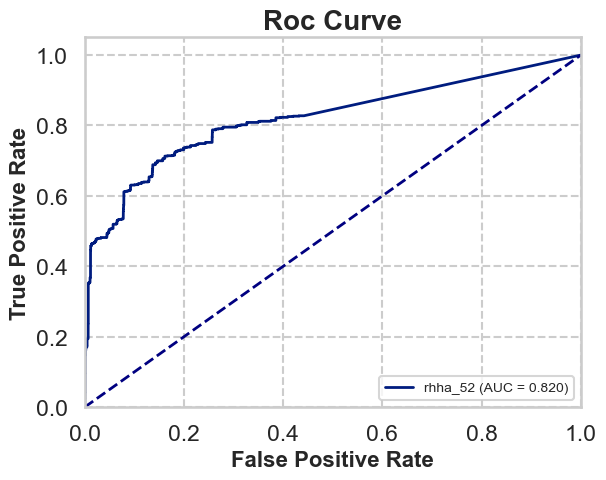

In [146]:
ph4 = pharmacophore_validation(data = df_best, active = 'Active' , predict = "rhha_52_predict", 
                                   scores = "rhha_52_rescore", model = "rhha_52", auc_thresh = 0.6)
ph4.validation()

In [5]:
df_train_rhha_52

,Active,rhha_52_rescore,rhha_52_predict
5711,0,0.243849,1.0
42915,0,0.303672,1.0
26797,0,0.329543,1.0
24470,0,0.491968,1.0
15916,0,0.145413,1.0
...,...,...,...
14037,0,0.356568,1.0
11028,0,0.000000,0.0
19038,0,0.000000,0.0
21054,0,0.453071,1.0


AUC = 0.822±0.027
GH = 0.13±0.006
F1 = 0.07±0.004
EF1 = 21.888±3.642


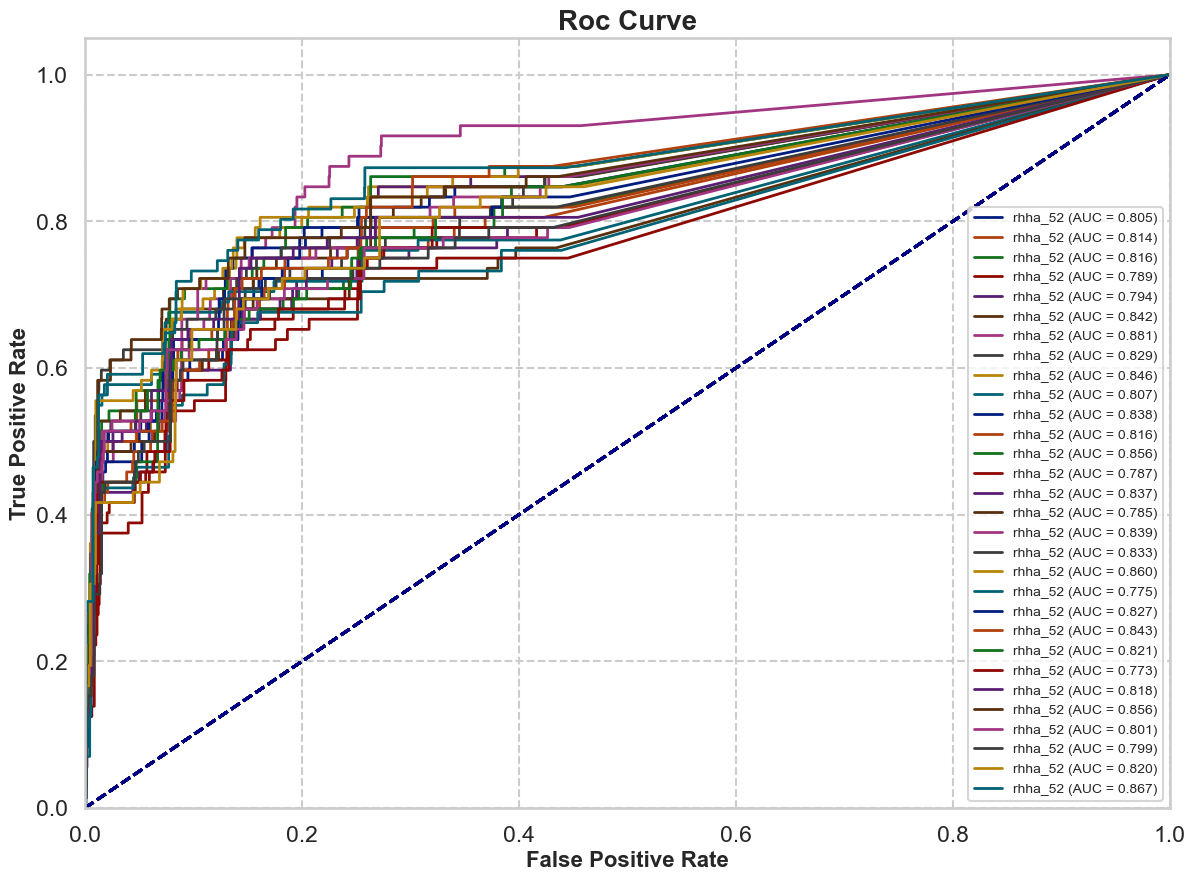

In [13]:
#Internal
cv = RepeatedStratifiedKFold(n_repeats = 3, n_splits=10, random_state=42)

table = internal_validation(data = df_train_rhha_52, cv=cv, active = 'Active', model = "rhha_52",  
                        predict = "rhha_52_predict", scores = "rhha_52_rescore")

auc_rhha_52, GH_rhha_52, f1_rhha_52, ef1_rhha_52  = table['AUCROC'].values,  table['GH'].values, table['F1-score'].values, table['EF1%'].values

print(f'AUC = {round(np.mean(auc_rhha_52),3)}±{round(np.std(auc_rhha_52),3)}')
print(f'GH = {round(np.mean( GH_rhha_52),3)}±{round(np.std( GH_rhha_52),3)}')
print(f'F1 = {round(np.mean(f1_rhha_52),3)}±{round(np.std(f1_rhha_52),3)}')
print(f'EF1 = {round(np.mean(ef1_rhha_52),3)}±{round(np.std(ef1_rhha_52),3)}')

,Model,Sensitivity,Specificity,Precision,F1-score,AP,AUCROC,logAUCROC,BedROC,GH,EF1%,RIE
0,rhha_52,0.828,0.565,0.037,0.071,0.26,0.811,0.462,0.382,0.133,18.333,0.962


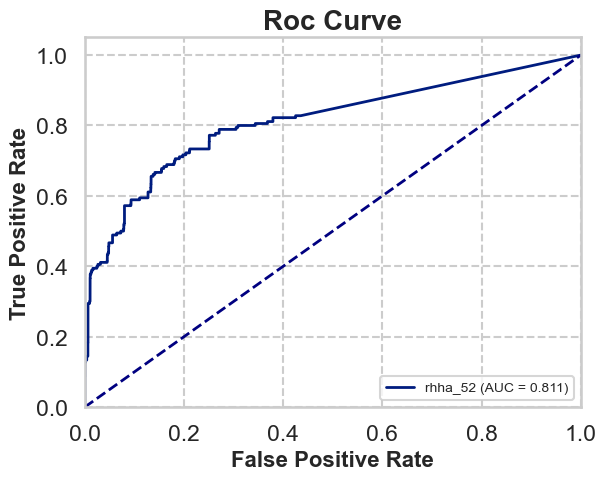

In [70]:
#External
ph4 = Validation.pharmacophore_validation(data = df_test_rhha_52, active = 'Active' , predict = "rhha_52_predict", 
                                   scores = "rhha_52_rescore", model = "rhha_52", auc_thresh = 0.6)
ph4.validation()
table = pd.DataFrame()
table = pd.concat([table, ph4.table], axis = 0)
table

# 3. Pharmacophore-predict Stacking- PS


In [11]:
import glob
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score,  roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import accuracy_score, make_scorer

path = f'{work_dir}/data-final'
model = []
list_auc_stacking = []
list_f1_stacking = []
list_GH_stacking = []
list_EF1_stacking = []

for i in glob.glob(f"{path}/*.csv"): 
    cha = pd.read_csv(i).drop(["Unnamed: 0"], axis = 1)
    file_name, file_extension = os.path.splitext(os.path.basename(i))
    print("*******************",file_name)
    model.append(file_name)
    
    score = []
    for j in cha.columns:
        if "predict" in j:
            score.append(j)
    data = pd.concat([cha.Active, cha[score]], axis = 1)
    display(data)
    
    #train_test_split

    X_train, X_test, y_train, y_test = train_test_split(data.drop(['Active'], axis = 1), 
                                                        data.Active, test_size=0.2, random_state=42, stratify = data.Active)
    
    #Internal: cross-validation
    print("*******Internal********")
    cv = RepeatedStratifiedKFold(n_repeats = 3, n_splits=10, random_state=42)
    clf = XGBClassifier(random_state=42)

    auc_stacking = cross_val_score(clf, X_train, y_train, cv=cv, scoring ='roc_auc')
    print(f'AUC = {round(np.mean(auc_stacking),3)}±{round(np.std(auc_stacking),3)}')
    list_auc_stacking.append(auc_stacking)
    
    GH_stacking = cross_val_score(clf, X_train, y_train, cv=cv, scoring =GH_scoring)
    print(f'GH = {round(np.mean(GH_stacking),3)}±{round(np.std(GH_stacking),3)}')
    list_GH_stacking.append(GH_stacking)
    
    f1_stacking = cross_val_score(clf, X_train, y_train, cv=cv, scoring ='f1')
    print(f'F1 = {round(np.mean(f1_stacking),3)}±{round(np.std(f1_stacking),3)}')
    list_f1_stacking.append(f1_stacking)
    
    EF1_stacking = cross_val_score(clf, X_train, y_train, cv=cv, scoring =EF1_scoring)
    print(f'EF1 = {round(np.mean(EF1_stacking),3)}±{round(np.std(EF1_stacking),3)}')
    list_EF1_stacking.append(EF1_stacking)
    
    
    
    #Extenal
    print("*******External********")
    clf =  XGBClassifier(random_state=42)
    clf = clf.fit(X_train, y_train)
    print(classification_report(y_test, clf.predict(X_test),))

    ext_f1_stacking, ext_auc_stacking, ext_gh_stacking, ext_ef1_stacking = get_external(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1])
    
    print('AUC =',  ext_auc_stacking)
    print('GH =', ext_gh_stacking)
    print('F1 =', ext_f1_stacking)
    print('EF1 =', ext_ef1_stacking)
    


******************* CPS1-AUC6


,Active,rhaa_1_predict,rhha_1_predict,rhha_11_predict,rhha_14_predict,rhha_3_predict,rhha_6_predict,rhha_7_predict,rhha_8_predict,rrha_1_predict
0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0
1,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
2,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
3,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
4,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
45200,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
45201,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
45202,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
45203,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


*******Internal********
AUC = 0.896±0.016


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

GH = 0.37±0.335
F1 = 0.024±0.024
EF1 = 49.675±1.05
*******External********
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8863
         1.0       1.00      0.01      0.01       178

    accuracy                           0.98      9041
   macro avg       0.99      0.50      0.50      9041
weighted avg       0.98      0.98      0.97      9041

AUC = 0.873945401093043
GH = 0.7514044943820225
F1 = 0.0111731843575419
EF1 = 50.561797752808985
******************* CPS1-AUC7


,Active,rhha_3_predict,rhha_6_predict,rhha_7_predict,rrha_1_predict
0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,0.0
2,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
45200,0.0,0.0,1.0,0.0,0.0
45201,0.0,0.0,1.0,1.0,0.0
45202,0.0,1.0,0.0,1.0,0.0
45203,0.0,0.0,1.0,0.0,0.0


*******Internal********
AUC = 0.834±0.02


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

GH = 0.0±0.0
F1 = 0.0±0.0
EF1 = 50.423±0.345
*******External********


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8863
         1.0       0.00      0.00      0.00       178

    accuracy                           0.98      9041
   macro avg       0.49      0.50      0.50      9041
weighted avg       0.96      0.98      0.97      9041

AUC = 0.8385828219070064
GH = 0.0
F1 = 0.0
EF1 = 50.561797752808985
******************* CPS25-AUC6


,Active,hhha_14_predict,hhha_23_predict,hhha_37_predict,hhha_7_predict,rhaa_2_predict,rhaa_3_predict,rhaa_5_predict,rhaa_7_predict,rhha_10_predict,...,rhha_52_predict,rhha_54_predict,rhha_56_predict,rhha_57_predict,rhha_6_predict,rhha_60_predict,rhha_64_predict,rrha_2_predict,rrha_4_predict,rrha_5_predict
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45207,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
45210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


*******Internal********
AUC = 0.992±0.006
GH = 0.869±0.03
F1 = 0.847±0.035
EF1 = 50.07±0.211
*******External********
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8863
         1.0       0.88      0.77      0.82       180

    accuracy                           0.99      9043
   macro avg       0.94      0.88      0.91      9043
weighted avg       0.99      0.99      0.99      9043

AUC = 0.9877881830832298
GH = 0.8490782189751855
F1 = 0.8189910979228486
EF1 = 50.0
******************* CPS25-AUC7


,Active,hhha_14_predict,hhha_37_predict,hhha_7_predict,rhha_10_predict,rhha_52_predict,rhha_54_predict,rrha_4_predict
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
45207,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
45208,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
45209,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
45210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


*******Internal********
AUC = 0.959±0.011
GH = 0.444±0.061
F1 = 0.26±0.059
EF1 = 34.444±5.928
*******External********
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8863
         1.0       0.50      0.18      0.27       180

    accuracy                           0.98      9043
   macro avg       0.74      0.59      0.63      9043
weighted avg       0.97      0.98      0.98      9043

AUC = 0.9576544811764263
GH = 0.4192664259656249
F1 = 0.26829268292682923
EF1 = 31.666666666666664
******************* CPS5-AUC6


,Active,hhaa_11_predict,hhaa_15_predict,hhaa_17_predict,rhaa_7_predict,rhaa_9_predict,rhha_12_predict,rhha_18_predict,rhha_21_predict,rhha_24_predict,...,rhha_33_predict,rhha_53_predict,rhha_63_predict,rhha_7_predict,rhha_8_predict,rrha_1_predict,rrha_11_predict,rrha_2_predict,rrha_4_predict,rrha_8_predict
0,1,0,0,0,0,0,1,0,0,1,...,1,1,0,1,1,0,1,1,1,0
1,1,0,0,0,0,0,1,1,0,1,...,1,1,1,1,1,0,0,0,0,1
2,1,0,0,0,1,1,0,0,0,1,...,1,1,0,1,1,1,1,1,1,0
3,1,0,0,0,0,0,1,1,0,1,...,1,1,1,0,1,0,0,0,0,1
4,1,0,0,0,0,0,1,1,0,1,...,1,1,0,0,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45207,0,0,0,0,0,1,1,1,0,0,...,0,0,1,1,1,0,0,0,0,0
45208,0,0,0,0,0,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
45209,0,0,0,0,1,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
45210,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,1,0,0,0,0,0


*******Internal********
AUC = 0.955±0.013
GH = 0.66±0.061
F1 = 0.549±0.057
EF1 = 43.441±4.693
*******External********
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      8863
           1       0.70      0.42      0.53       180

    accuracy                           0.98      9043
   macro avg       0.84      0.71      0.76      9043
weighted avg       0.98      0.98      0.98      9043

AUC = 0.9430914413228528
GH = 0.6261512457785594
F1 = 0.5259515570934256
EF1 = 42.22222222222222
******************* CPS5-AUC7


,Active,rhha_53_predict,rhha_8_predict,rrha_4_predict
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0
...,...,...,...,...
45207,0.0,0.0,1.0,0.0
45208,0.0,1.0,0.0,0.0
45209,0.0,0.0,0.0,0.0
45210,0.0,0.0,1.0,0.0


*******Internal********
AUC = 0.852±0.022


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

GH = 0.0±0.0
F1 = 0.0±0.0
EF1 = 50.07±0.211
*******External********


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8863
         1.0       0.00      0.00      0.00       180

    accuracy                           0.98      9043
   macro avg       0.49      0.50      0.49      9043
weighted avg       0.96      0.98      0.97      9043

AUC = 0.8507512505171311
GH = 0.0
F1 = 0.0
EF1 = 50.0
******************* CPS50-AUC6


,Active,hhaa_21_predict,hhaa_33_predict,hhha_18_predict,hhha_50_predict,hhha_52_predict,hhha_56_predict,hhha_58_predict,hhha_68_predict,hhha_71_predict,...,rhha_96_predict,rhhh_12_predict,rhhh_19_predict,rrha_16_predict,rrha_21_predict,rrha_26_predict,rrha_4_predict,rrha_5_predict,rrha_8_predict,rrhh_6_predict
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45207,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45208,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45209,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45210,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


*******Internal********
AUC = 0.992±0.008
GH = 0.927±0.022
F1 = 0.882±0.033
EF1 = 50.07±0.211
*******External********
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8863
         1.0       0.95      0.81      0.87       180

    accuracy                           1.00      9043
   macro avg       0.98      0.90      0.94      9043
weighted avg       1.00      1.00      1.00      9043

AUC = 0.984946782504043
GH = 0.916125287267588
F1 = 0.8734939759036146
EF1 = 50.0
******************* CPS50-AUC7


,Active,rhha_57_predict,rhha_96_predict,rrha_16_predict,rrha_4_predict,rrha_8_predict,rrhh_6_predict
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
45207,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45208,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45209,0.0,0.0,0.0,0.0,0.0,0.0,1.0
45210,0.0,1.0,0.0,0.0,0.0,0.0,1.0


*******Internal********
AUC = 0.908±0.02
GH = 0.45±0.068
F1 = 0.278±0.054
EF1 = 33.791±4.234
*******External********
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8863
         1.0       0.39      0.14      0.21       180

    accuracy                           0.98      9043
   macro avg       0.69      0.57      0.60      9043
weighted avg       0.97      0.98      0.97      9043

AUC = 0.8950860004763875
GH = 0.33006925283524624
F1 = 0.21138211382113817
EF1 = 27.77777777777778
******************* CPS75-AUC6


,Active,hhaa_69_predict,hhha_19_predict,hhha_35_predict,hhha_37_predict,hhha_51_predict,rhha_1_predict,rhha_100_predict,rhha_107_predict,rhha_108_predict,...,rhha_81_predict,rhha_82_predict,rhha_89_predict,rhhh_15_predict,rhhh_5_predict,rrha_15_predict,rrha_18_predict,rrha_27_predict,rrha_3_predict,rrha_4_predict
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45207,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45208,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
45209,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45210,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


*******Internal********
AUC = 0.98±0.012
GH = 0.857±0.037
F1 = 0.809±0.044
EF1 = 50.07±0.211
*******External********
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      8863
         1.0       0.89      0.73      0.80       180

    accuracy                           0.99      9043
   macro avg       0.94      0.86      0.90      9043
weighted avg       0.99      0.99      0.99      9043

AUC = 0.9649234645906202
GH = 0.848776759378015
F1 = 0.8012232415902141
EF1 = 50.0
******************* CPS75-AUC7


,Active,rrha_15_predict,rrha_3_predict
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,1.0,0.0
3,1.0,1.0,0.0
4,1.0,0.0,0.0
...,...,...,...
45207,0.0,0.0,0.0
45208,0.0,0.0,0.0
45209,0.0,0.0,0.0
45210,0.0,0.0,0.0


*******Internal********
AUC = 0.803±0.023


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

GH = 0.0±0.0
F1 = 0.0±0.0
EF1 = 50.07±0.211
*******External********
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99      8863
         1.0       0.00      0.00      0.00       180

    accuracy                           0.98      9043
   macro avg       0.49      0.50      0.49      9043
weighted avg       0.96      0.98      0.97      9043

AUC = 0.7768942670527913
GH = 0.0
F1 = 0.0
EF1 = 50.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metr

In [15]:
index_stacking = ['Model', "AUC_stacking", "F1_stacking", "GH_stacking","EF1_stacking"]
metric_stacking =[model, list_auc_stacking, list_f1_stacking, list_GH_stacking,list_EF1_stacking]
table_stacking = pd.DataFrame(data = metric_stacking, index = index_stacking).T

name = pd.DataFrame({
    'Name': ['A(AUC≥0.6)', 'A(AUC≥0.7)',
            'C(AUC≥0.6)', 'C(AUC≥0.7)',
            'B(AUC≥0.6)', 'B(AUC≥0.7)',
             'D(AUC≥0.6)',  'D(AUC≥0.7)',
             'E(AUC≥0.6)',  'E(AUC≥0.7)']
})

table_name = pd.concat([name,table_stacking], axis = 1)
table_name.sort_values(['Name'], ascending=True, inplace= True)
table_stacking = table_name[["Name","AUC_stacking","F1_stacking","GH_stacking","EF1_stacking"]]

In [16]:
table0 = pd.DataFrame(["RHHa_52",auc_rhha_52,f1_rhha_52,GH_rhha_52,ef1_rhha_52], index =table_stacking.columns ).T
table_compare_stacking = pd.concat([table0,table_stacking])
table_compare_stacking

,Name,AUC_stacking,F1_stacking,GH_stacking,EF1_stacking
0,RHHa_52,"[0.805, 0.814, 0.816, 0.789, 0.794, 0.842, 0.8...","[0.067, 0.071, 0.069, 0.067, 0.067, 0.071, 0.0...","[0.125, 0.132, 0.13, 0.126, 0.126, 0.132, 0.14...","[19.444, 18.056, 20.833, 13.889, 19.444, 25.0,..."
0,A(AUC≥0.6),"[0.9258697696285849, 0.8769178028522175, 0.887...","[0.05333333333333333, 0.0273972602739726, 0.0,...","[0.5068014417802852, 0.7534722222222222, 0.0, ...","[48.611111111111114, 50.0, 48.611111111111114,..."
1,A(AUC≥0.7),"[0.8580296975395706, 0.8293801911926031, 0.803...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.0, 50.0, 50.0, 50.0, 50.70422535211268, 50..."
4,B(AUC≥0.6),"[0.9527640651935434, 0.9713935903463407, 0.943...","[0.5, 0.6017699115044247, 0.509090909090909, 0...","[0.6201159692838112, 0.7385455487135971, 0.648...","[38.88888888888889, 47.22222222222222, 38.8888..."
5,B(AUC≥0.7),"[0.8478765083842658, 0.8418175050932455, 0.836...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50...."
2,C(AUC≥0.6),"[0.9939233662435355, 0.9973436765397273, 0.994...","[0.8428571428571429, 0.8613138686131386, 0.799...","[0.8534242281774016, 0.8841313906670043, 0.851...","[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50...."
3,C(AUC≥0.7),"[0.9662905500705219, 0.9650662121924465, 0.964...","[0.288659793814433, 0.21978021978021975, 0.224...","[0.46715702867889053, 0.4283687592276412, 0.47...","[34.72222222222222, 37.5, 40.27777777777778, 3..."
6,D(AUC≥0.6),"[0.9896372041999687, 0.9979666196520921, 0.991...","[0.9264705882352942, 0.8970588235294118, 0.876...","[0.9567612834978844, 0.9258651171446483, 0.934...","[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50...."
7,D(AUC≥0.7),"[0.8774858956276446, 0.8796113461839837, 0.901...","[0.2417582417582418, 0.23157894736842105, 0.27...","[0.4713388946626086, 0.3955466040487044, 0.508...","[38.88888888888889, 33.333333333333336, 38.888..."
8,E(AUC≥0.6),"[0.9803851277229274, 0.9906166745024291, 0.978...","[0.796875, 0.8529411764705882, 0.7751937984496...","[0.8589059036872859, 0.8795851453533928, 0.829...","[50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50...."


In [17]:
AUC_stacking = pd.DataFrame(list(table_compare_stacking["AUC_stacking"]), index = table_compare_stacking["Name"]).T
F1_stacking = pd.DataFrame(list(table_compare_stacking["F1_stacking"]), index =  table_compare_stacking["Name"]).T
GH_stacking = pd.DataFrame(list(table_compare_stacking["GH_stacking"]), index =  table_compare_stacking["Name"]).T
EF1_stacking = pd.DataFrame(list(table_compare_stacking["EF1_stacking"]), index =  table_compare_stacking["Name"]).T
AUC_stacking.head()

Name,RHHa_52,A(AUC≥0.6),A(AUC≥0.7),B(AUC≥0.6),B(AUC≥0.7),C(AUC≥0.6),C(AUC≥0.7),D(AUC≥0.6),D(AUC≥0.7),E(AUC≥0.6),E(AUC≥0.7)
0,0.805,0.925870,0.858030,0.952764,0.847877,0.993923,0.966291,0.989637,0.877486,0.980385,0.771321
1,0.814,0.876918,0.829380,0.971394,0.841818,0.997344,0.965066,0.997967,0.879611,0.990617,0.771115
2,0.816,0.887643,0.803009,0.943426,0.836021,0.994425,0.964955,0.991208,0.901113,0.978655,0.837236
3,0.789,0.895545,0.851305,0.938049,0.842724,0.974920,0.925923,0.976363,0.887447,0.971068,0.768310
4,0.794,0.913264,0.869646,0.952799,0.816888,0.984011,0.953747,0.997050,0.912020,0.984881,0.784989


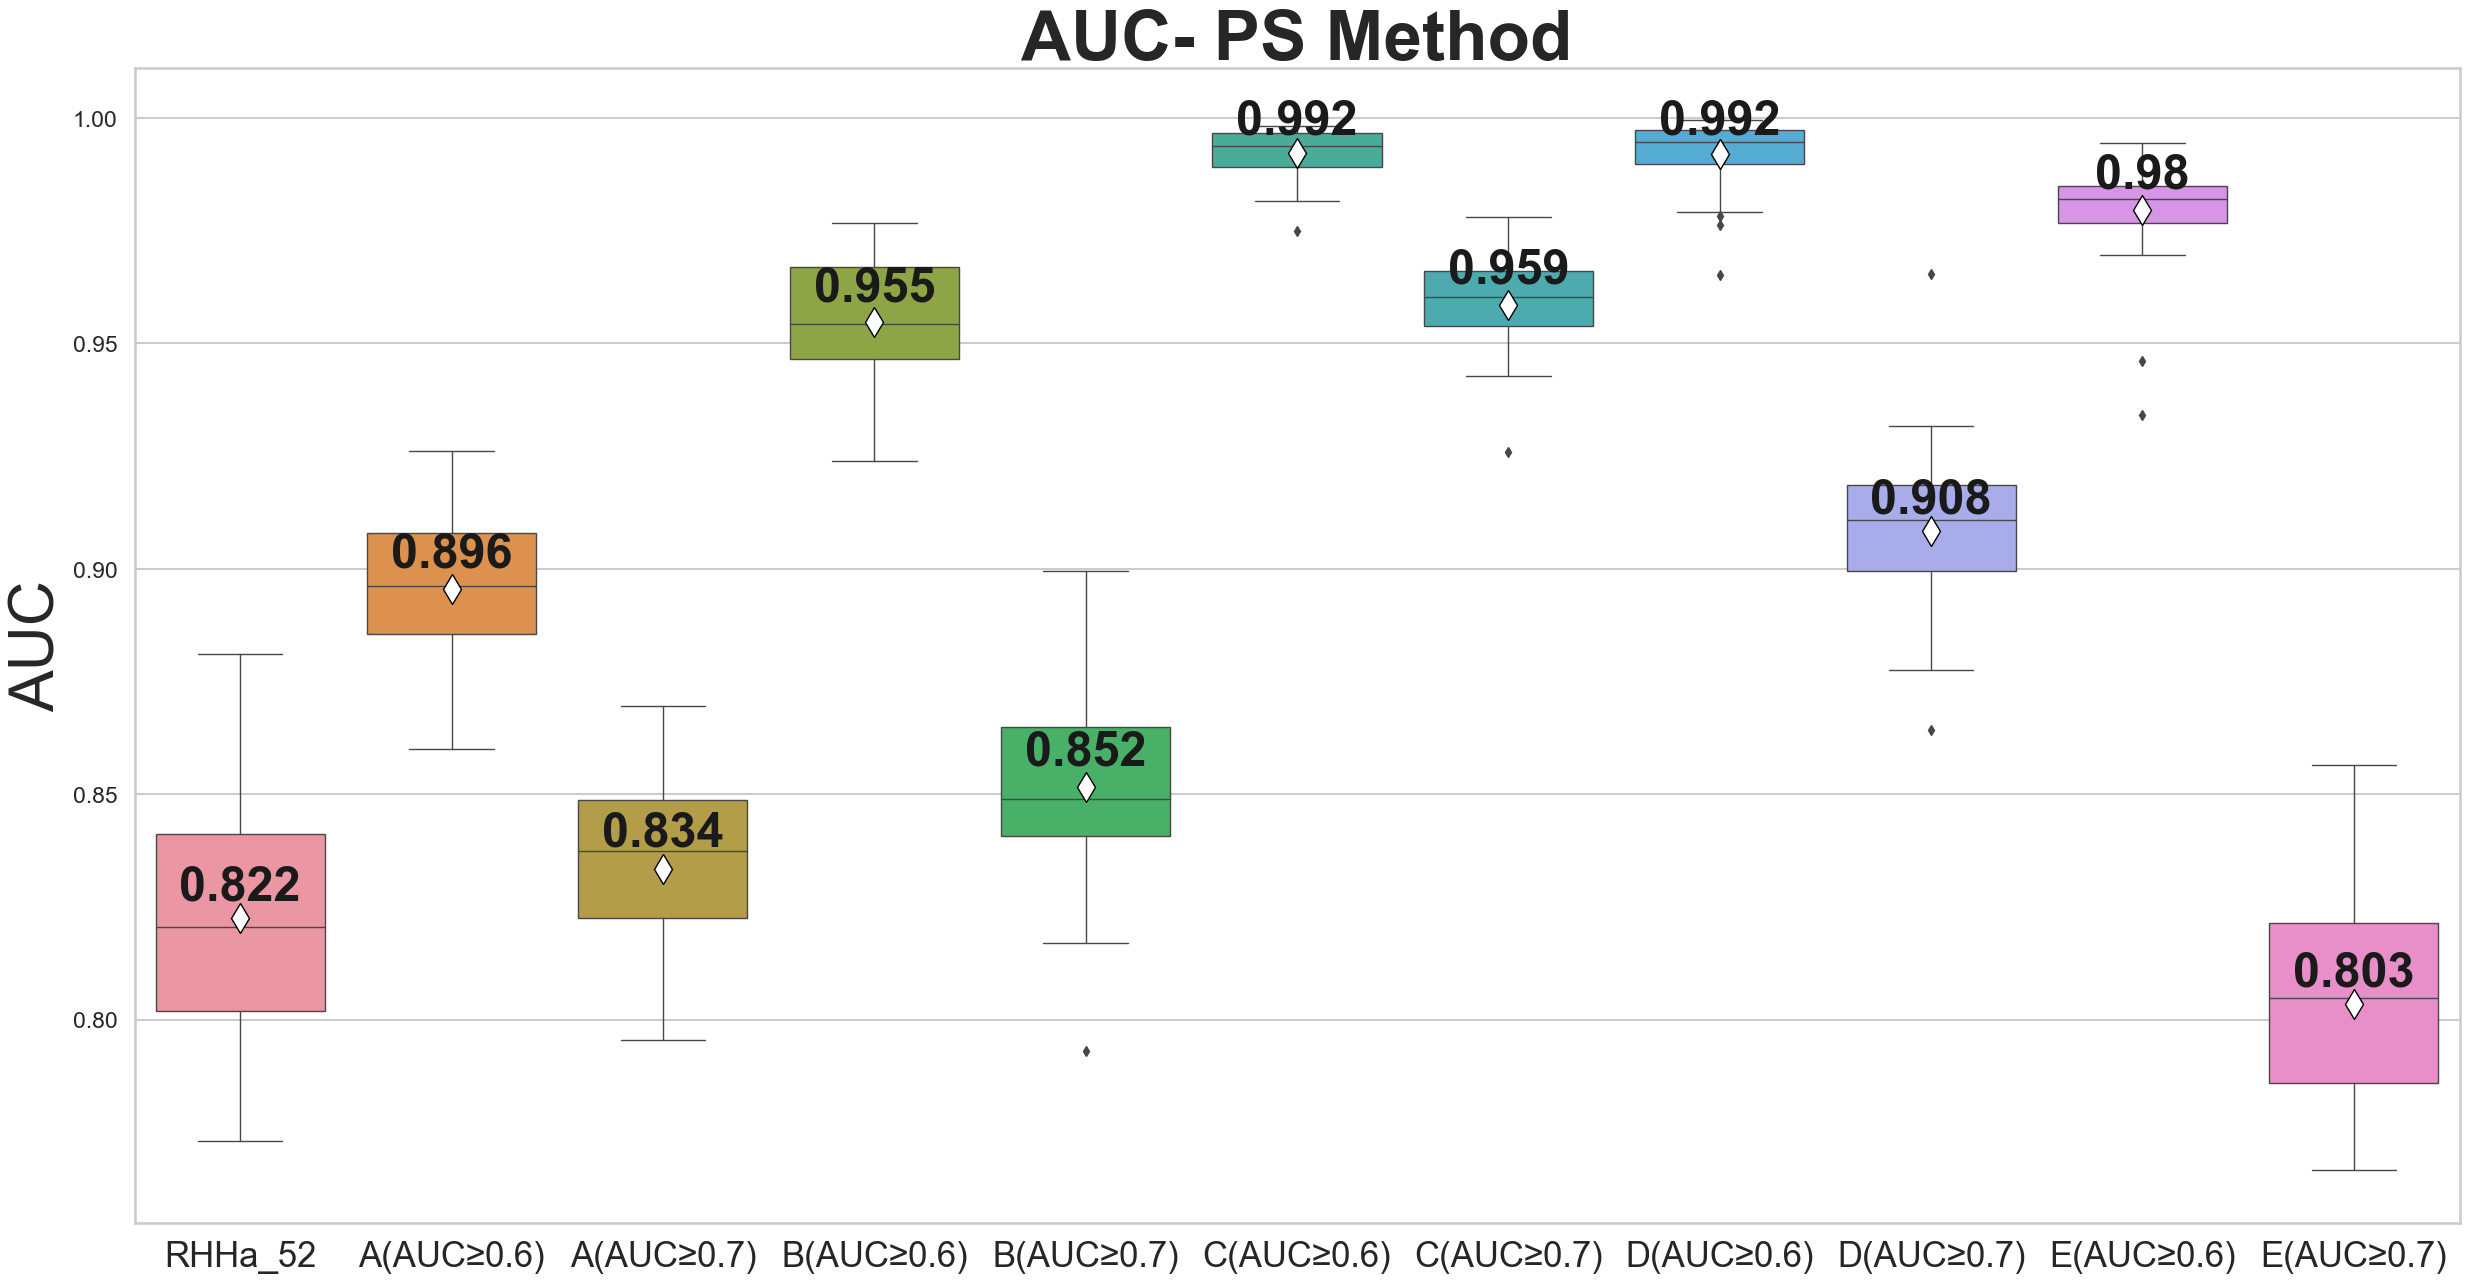

In [65]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = pd.melt(AUC_stacking.reset_index(), id_vars=['index'], value_vars=AUC_stacking.columns)
df_melt.columns = ['index', 'Name', 'AUC']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
                
plt.figure(figsize = (30,15))

ax = sns.boxplot(x='Name', y='AUC', data=df_melt , showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"15"})

mean = round(AUC_stacking.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =AUC_stacking.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.005

for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], 
    horizontalalignment='center',color='k',weight='semibold', fontsize = 35)


ax.set_ylabel('AUC', fontsize = 45)
ax.set_xlabel(None)
ax.set_xticklabels(table_compare_stacking['Name'], fontsize = 25)
ax.set_title("AUC- PS Method",fontsize = 50, weight ='semibold')
plt.savefig(f"{work_dir}/image-stacking/AUC- Stacking Comparison- Wilcoxon test.png", dpi = 600)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


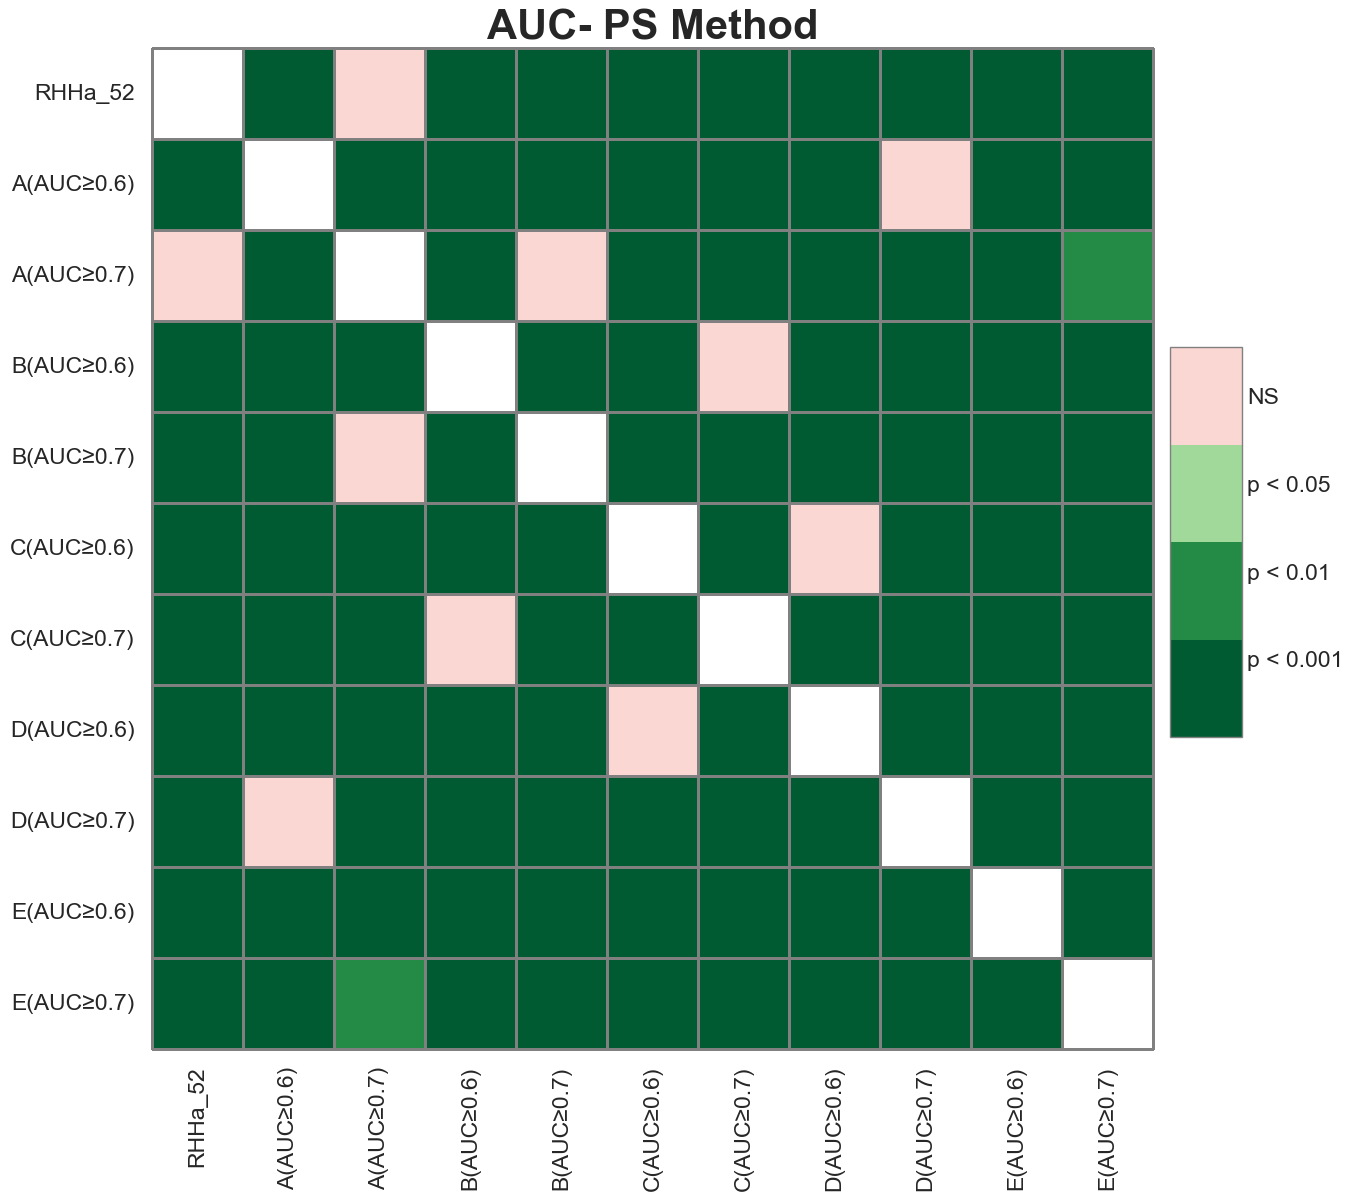

In [19]:
pc =sp.posthoc_wilcoxon(df_melt, val_col='AUC', group_col='Name', p_adjust='holm')
plt.figure(figsize = (18,13))
plt.title("AUC- PS Method", fontsize = 30, weight = 'semibold')
heatmap_args = {'linewidths': 1, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sign_plot(pc, **heatmap_args)
plt.savefig(f"{work_dir}/image-stacking/AUC Comparison of Stacking Method- posthoc Wilcoxon test.png", dpi = 600)

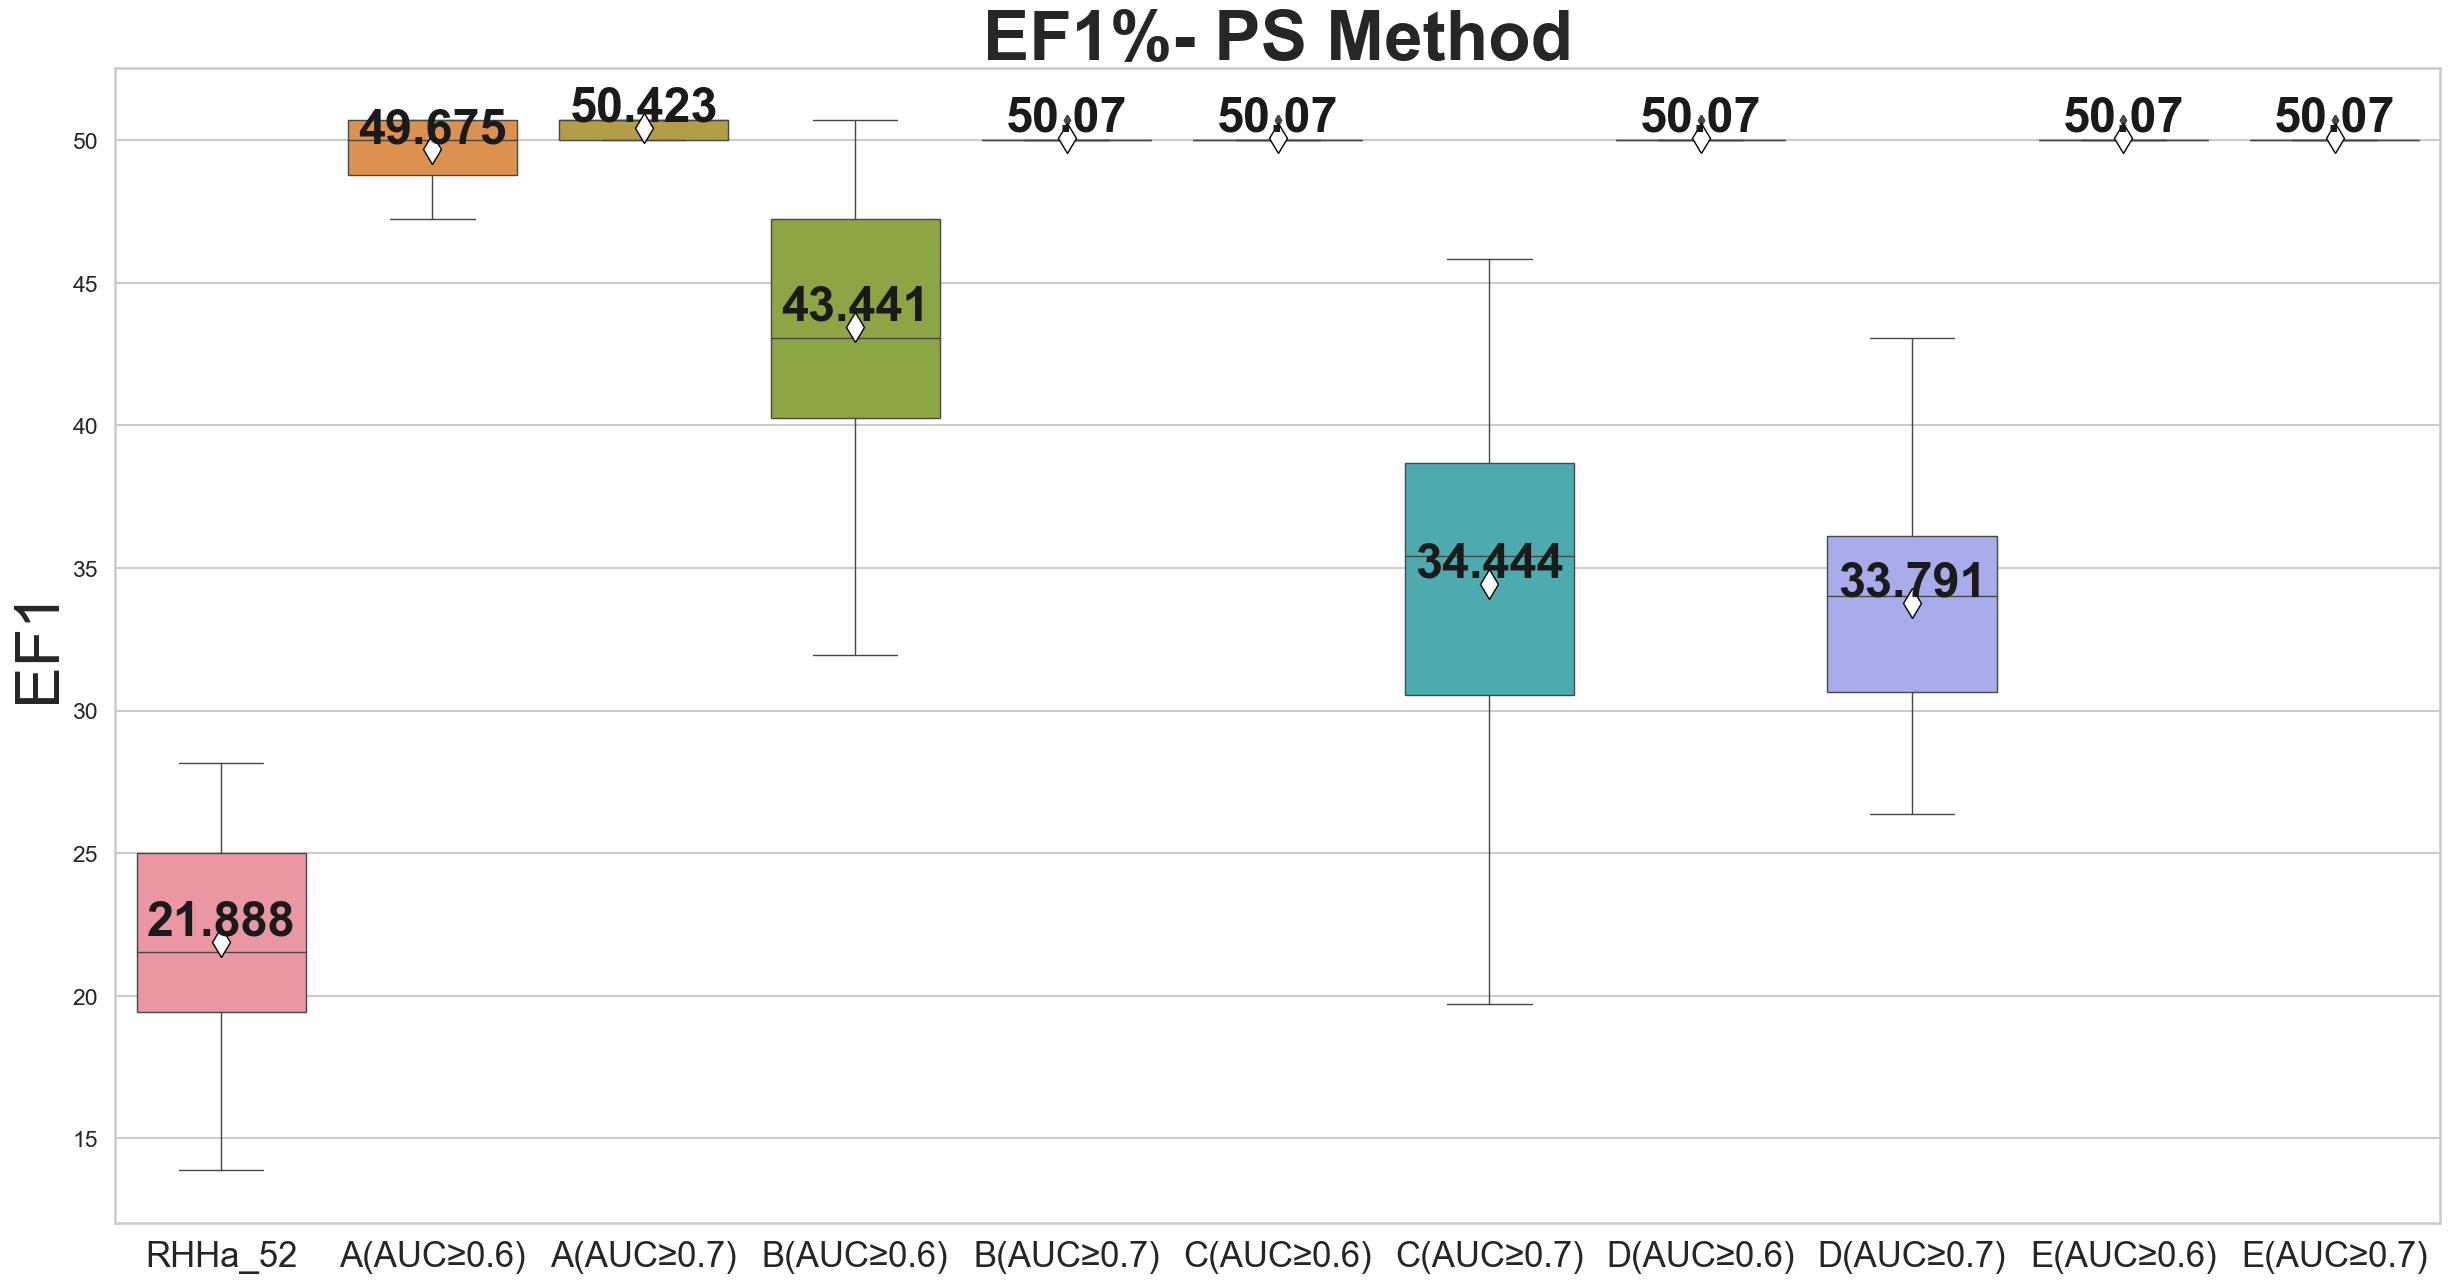

In [66]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = pd.melt(EF1_stacking.reset_index(), id_vars=['index'], value_vars=EF1_stacking.columns)
df_melt.columns = ['index', 'Name', 'EF1']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
                
plt.figure(figsize = (30,15))

ax = sns.boxplot(x='Name', y='EF1', data=df_melt , showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"15"})

mean = round(EF1_stacking.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =EF1_stacking.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.005

for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], 
    horizontalalignment='center',color='k',weight='semibold', fontsize = 35)


ax.set_ylabel('EF1', fontsize = 45)
ax.set_xlabel(None)
ax.set_xticklabels(table_compare_stacking['Name'], fontsize = 25)
ax.set_title("EF1%- PS Method",fontsize = 50, weight ='semibold')
plt.savefig(f"{work_dir}/image-stacking/EF1- Stacking Comparison- Wilcoxon test.png", dpi = 600)

In [23]:
name1 = ["RHHa_52",'A(AUC≥0.6)',
                    'B(AUC≥0.6)', 
                     'C(AUC≥0.6)', 'C(AUC≥0.7)',
                     'D(AUC≥0.6)',  'D(AUC≥0.7)',
                     'E(AUC≥0.6)'  ]

GH_stacking_new= GH_stacking[name1]

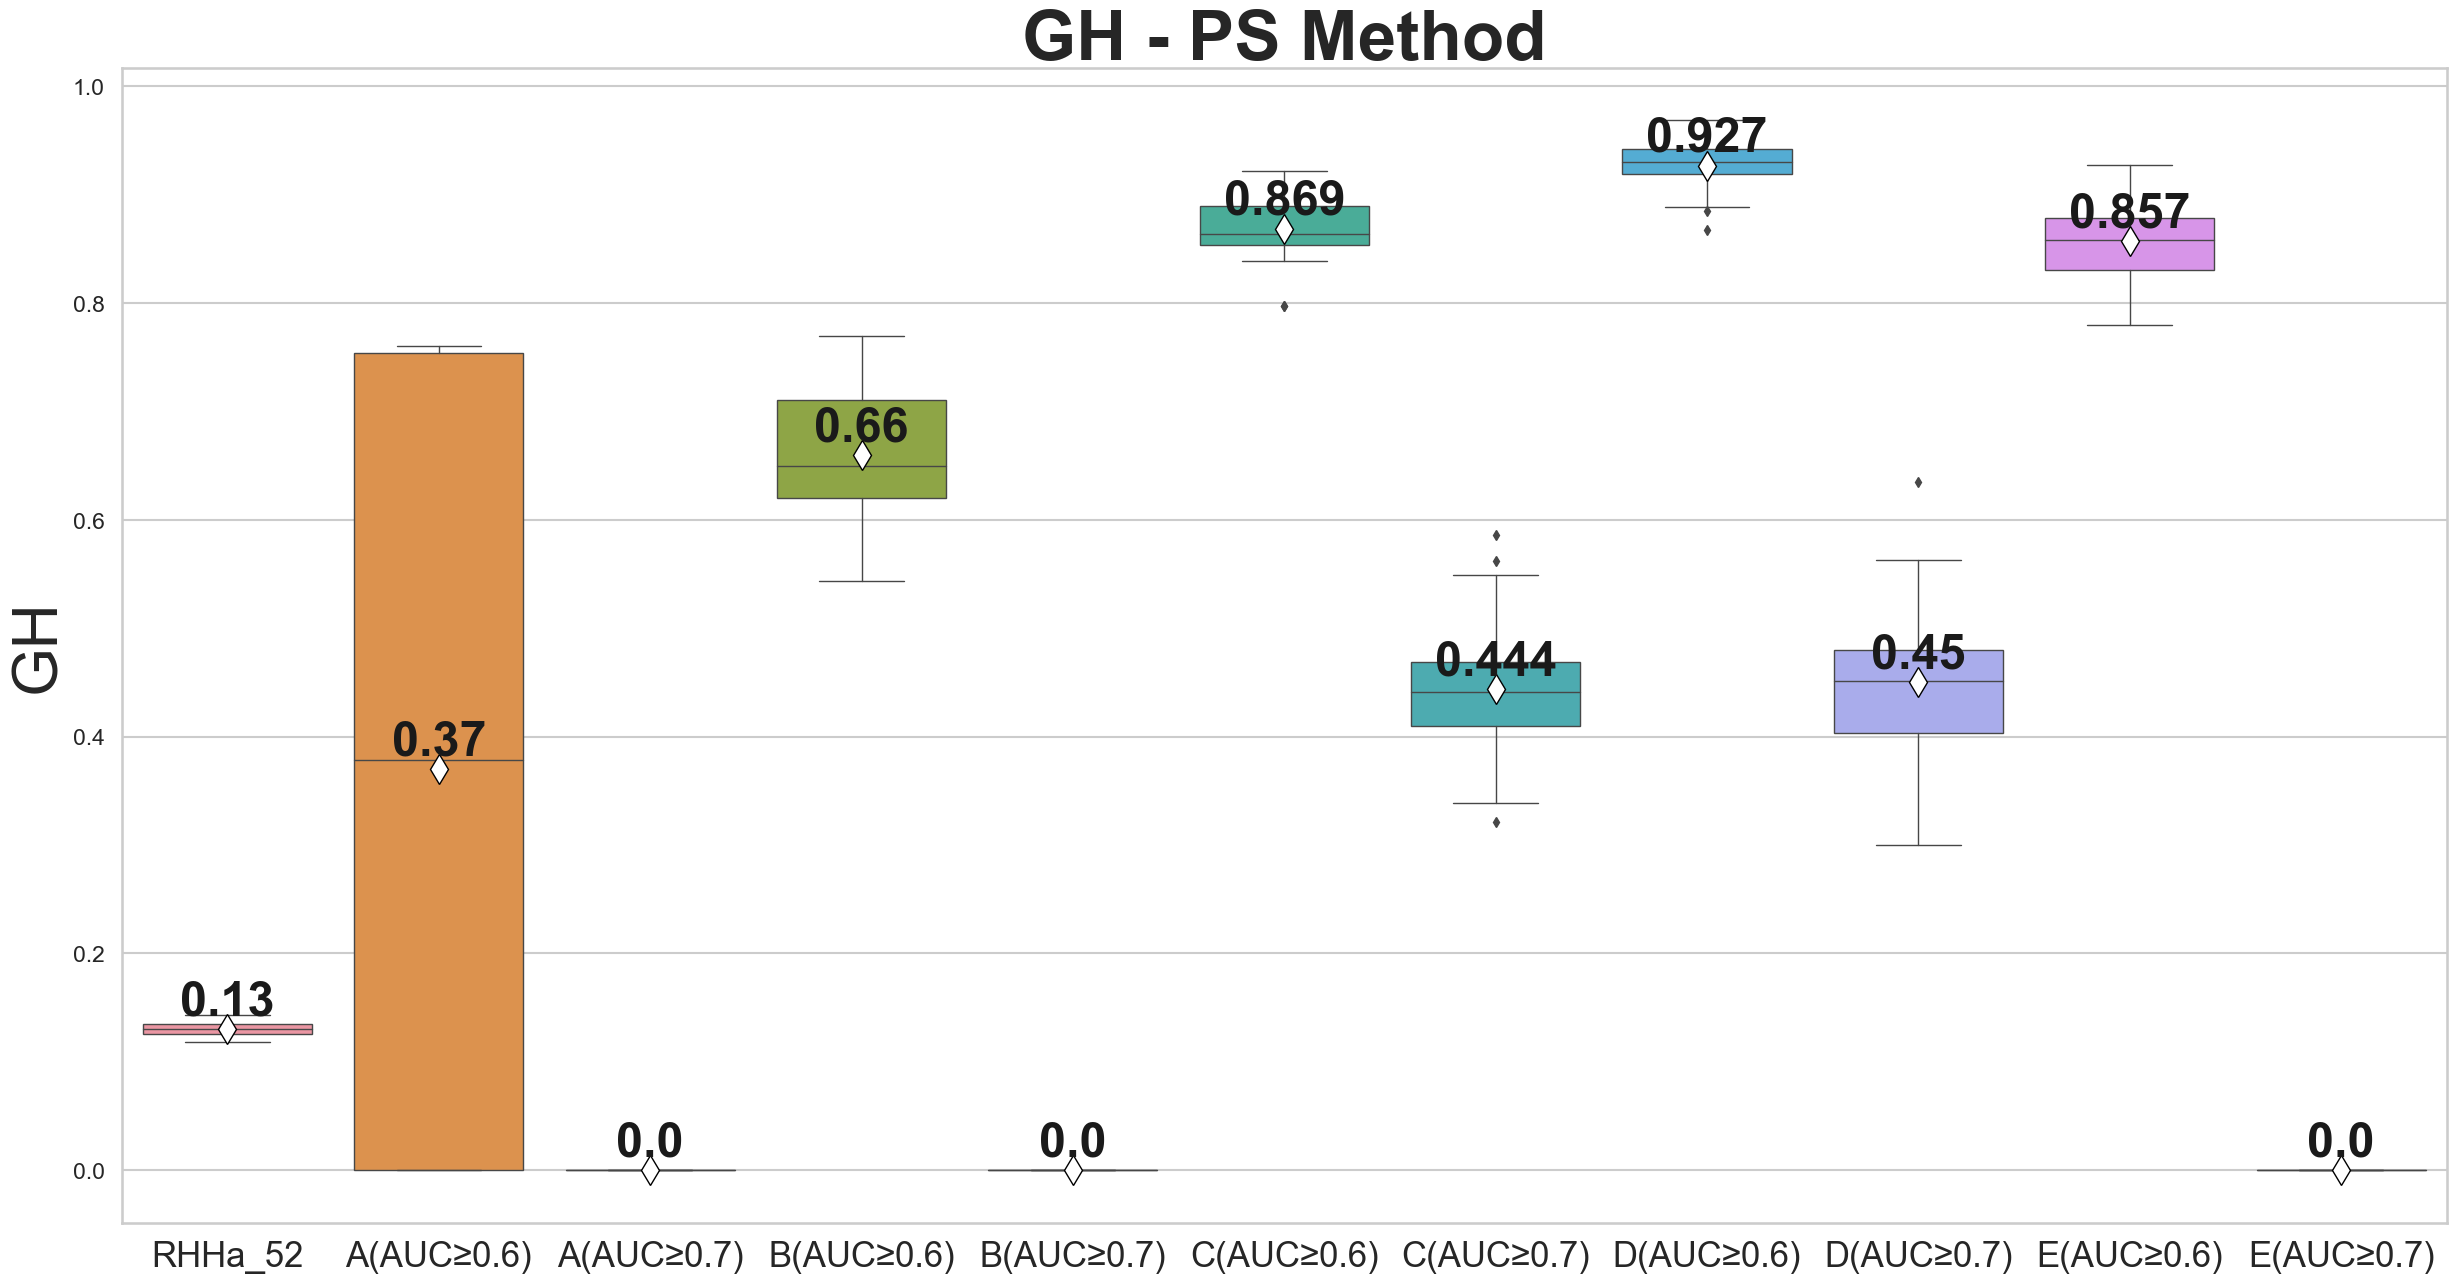

In [67]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = pd.melt(GH_stacking.reset_index(), id_vars=['index'], value_vars=GH_stacking.columns)
df_melt.columns = ['index', 'Name', 'GH']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
                
plt.figure(figsize = (30,15))

ax = sns.boxplot(x='Name', y='GH', data=df_melt , showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"15"})

mean = round(GH_stacking.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =GH_stacking.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.03

for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], 
    horizontalalignment='center',color='k',weight='semibold', fontsize = 35)


ax.set_ylabel('GH', fontsize = 45)
ax.set_xlabel(None)
ax.set_xticklabels(table_compare_stacking['Name'], fontsize = 25)
ax.set_title("GH - PS Method",fontsize = 50, weight ='semibold')
plt.savefig(f"{work_dir}/image-stacking/GH- Stacking Comparison- Wilcoxon test.png", dpi = 600)

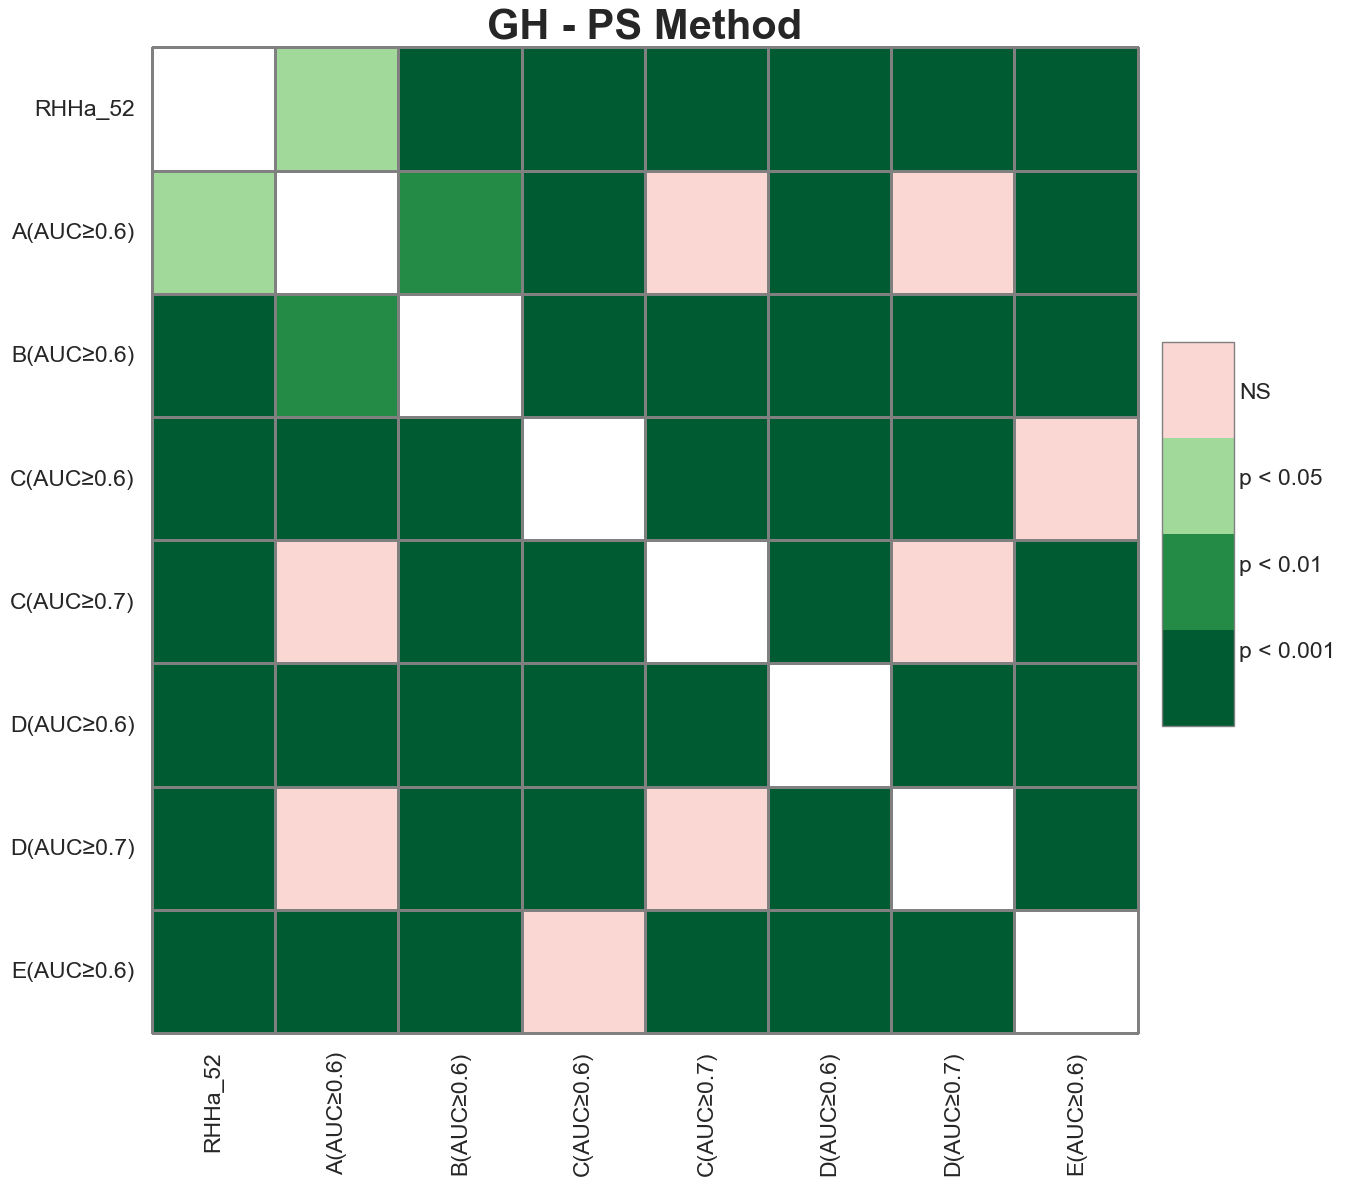

In [25]:
df_melt = pd.melt(GH_stacking_new.reset_index(), id_vars=['index'], value_vars=GH_stacking_new.columns)
df_melt.columns = ['index', 'Name', 'GH']
pc =sp.posthoc_wilcoxon(df_melt, val_col='GH', group_col='Name', p_adjust='holm')
plt.figure(figsize = (18,12.8))
plt.title("GH - PS Method", fontsize = 30, weight = 'semibold')
heatmap_args = {'linewidths': 1, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sign_plot(pc, **heatmap_args)
plt.savefig(f"{work_dir}/image-stacking/GH Comparison of Stacking Method- posthoc Wilcoxon test.png", dpi = 600)

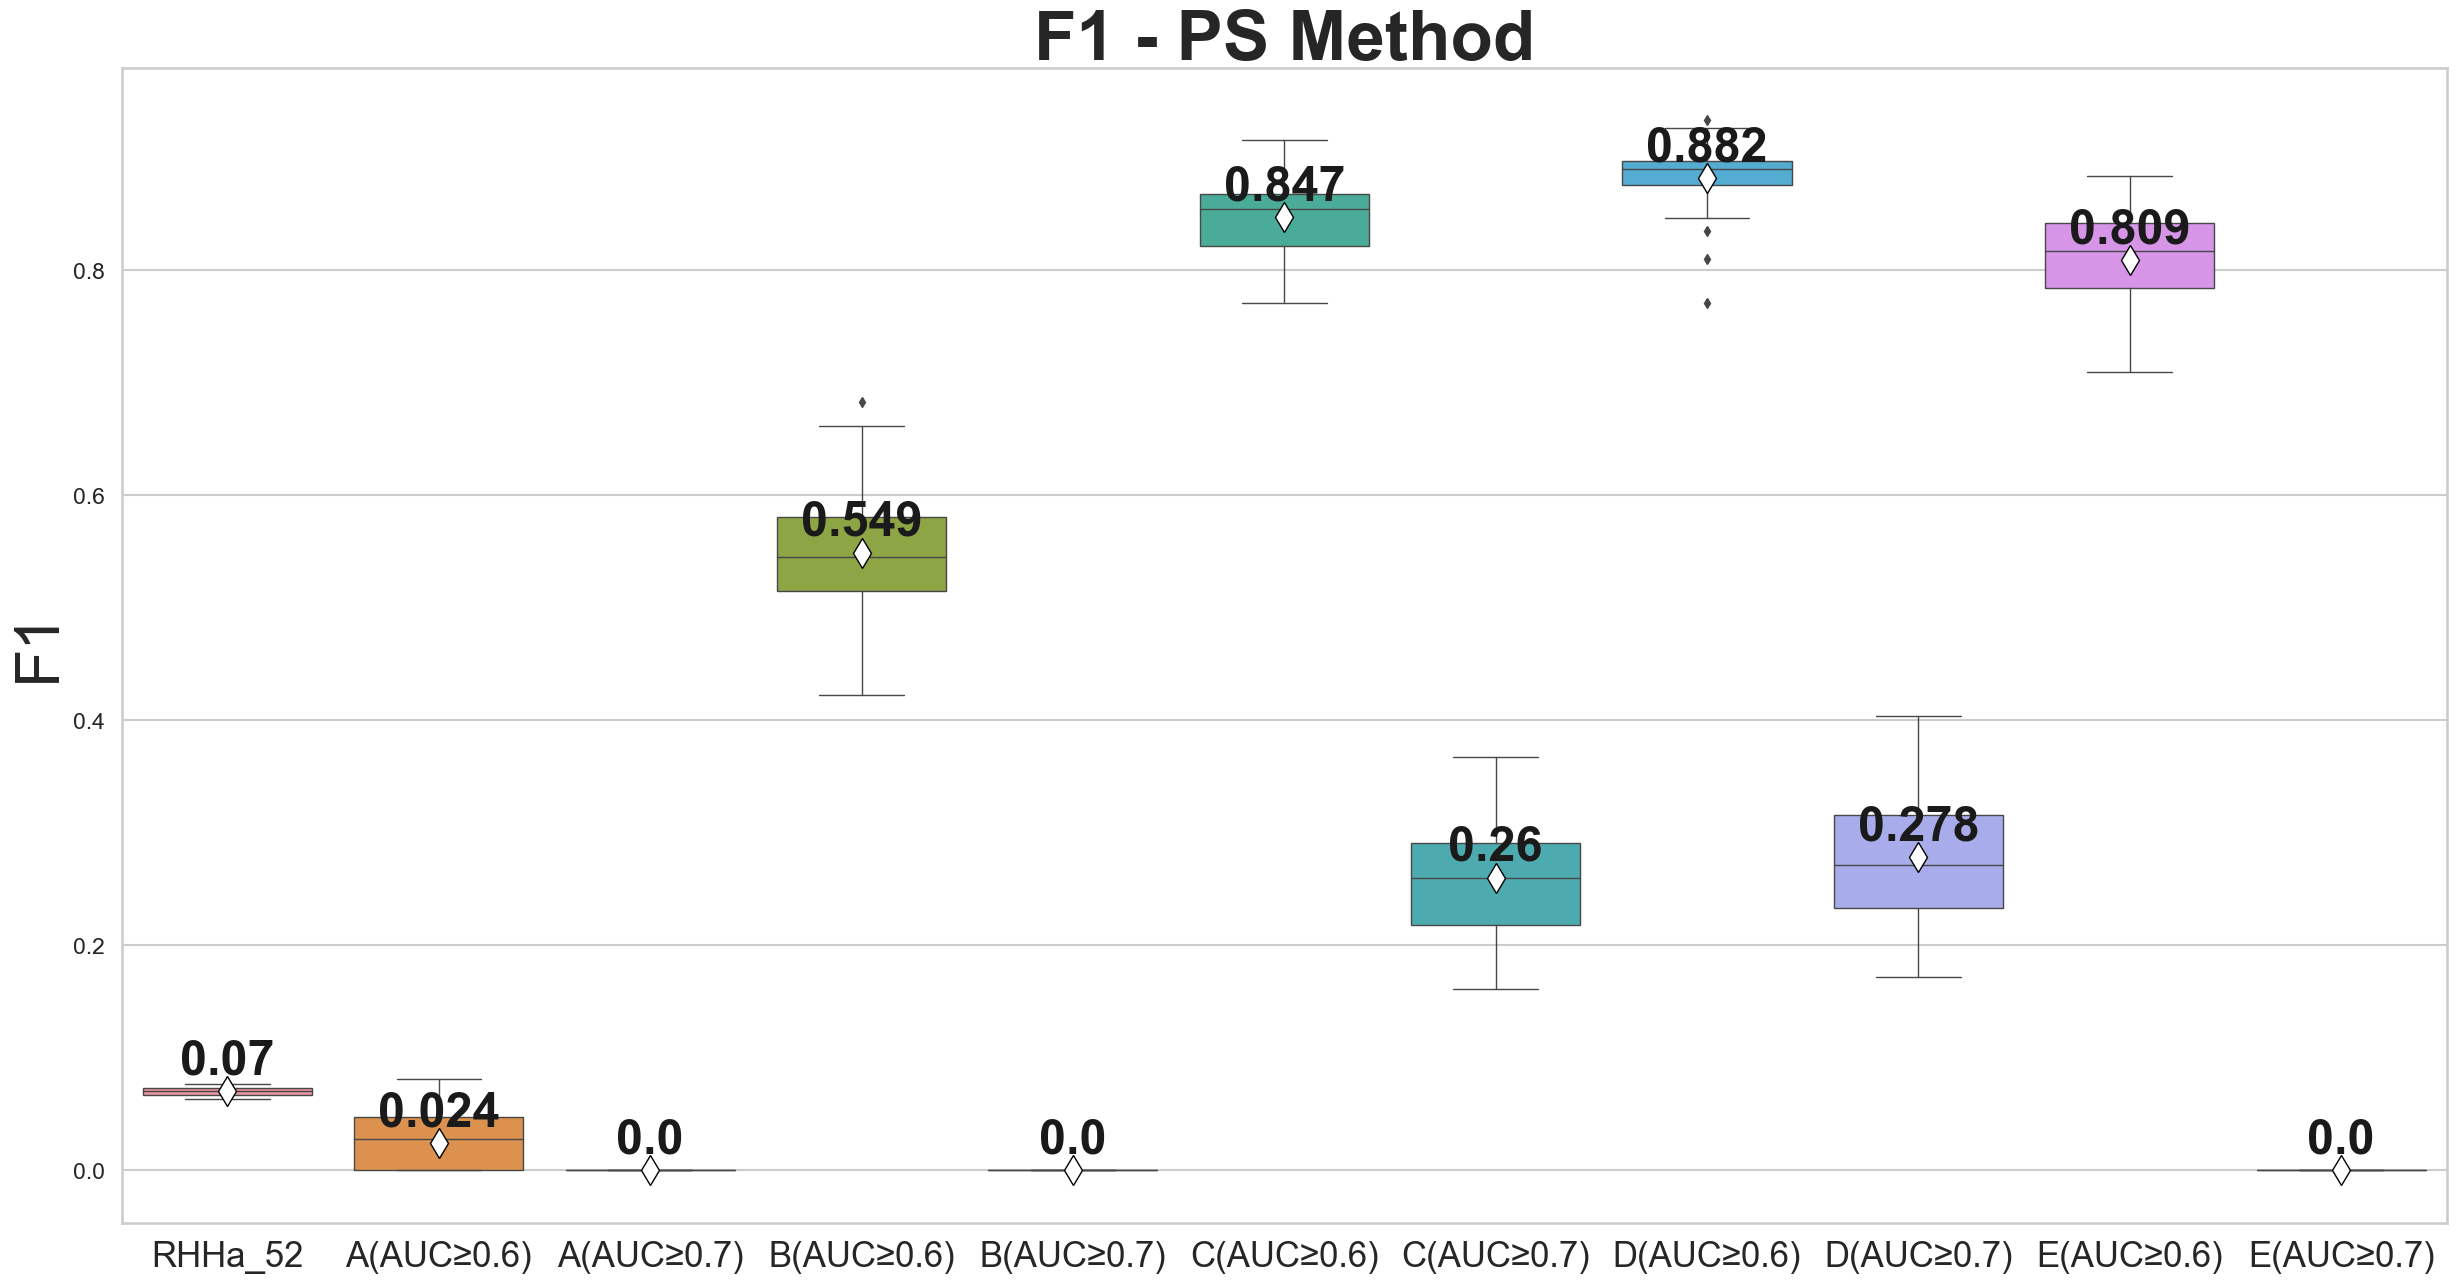

In [68]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = pd.melt(F1_stacking.reset_index(), id_vars=['index'], value_vars=F1_stacking.columns)
df_melt.columns = ['index', 'Name', 'F1']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)
                
plt.figure(figsize = (30,15))

ax = sns.boxplot(x='Name', y='F1', data=df_melt , showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"15"})

mean = round(F1_stacking.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =F1_stacking.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.06

for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], 
    horizontalalignment='center',color='k',weight='semibold', fontsize = 35)


ax.set_ylabel('F1', fontsize = 45)
ax.set_xlabel(None)
ax.set_xticklabels(table_compare_stacking['Name'], fontsize = 25)
ax.set_title("F1 - PS Method",fontsize = 50, weight ='semibold')
plt.savefig(f"{work_dir}/image-stacking/F1- Stacking Comparison- Wilcoxon test.png", dpi = 600)

In [27]:
F1_stacking_new= F1_stacking[name1]

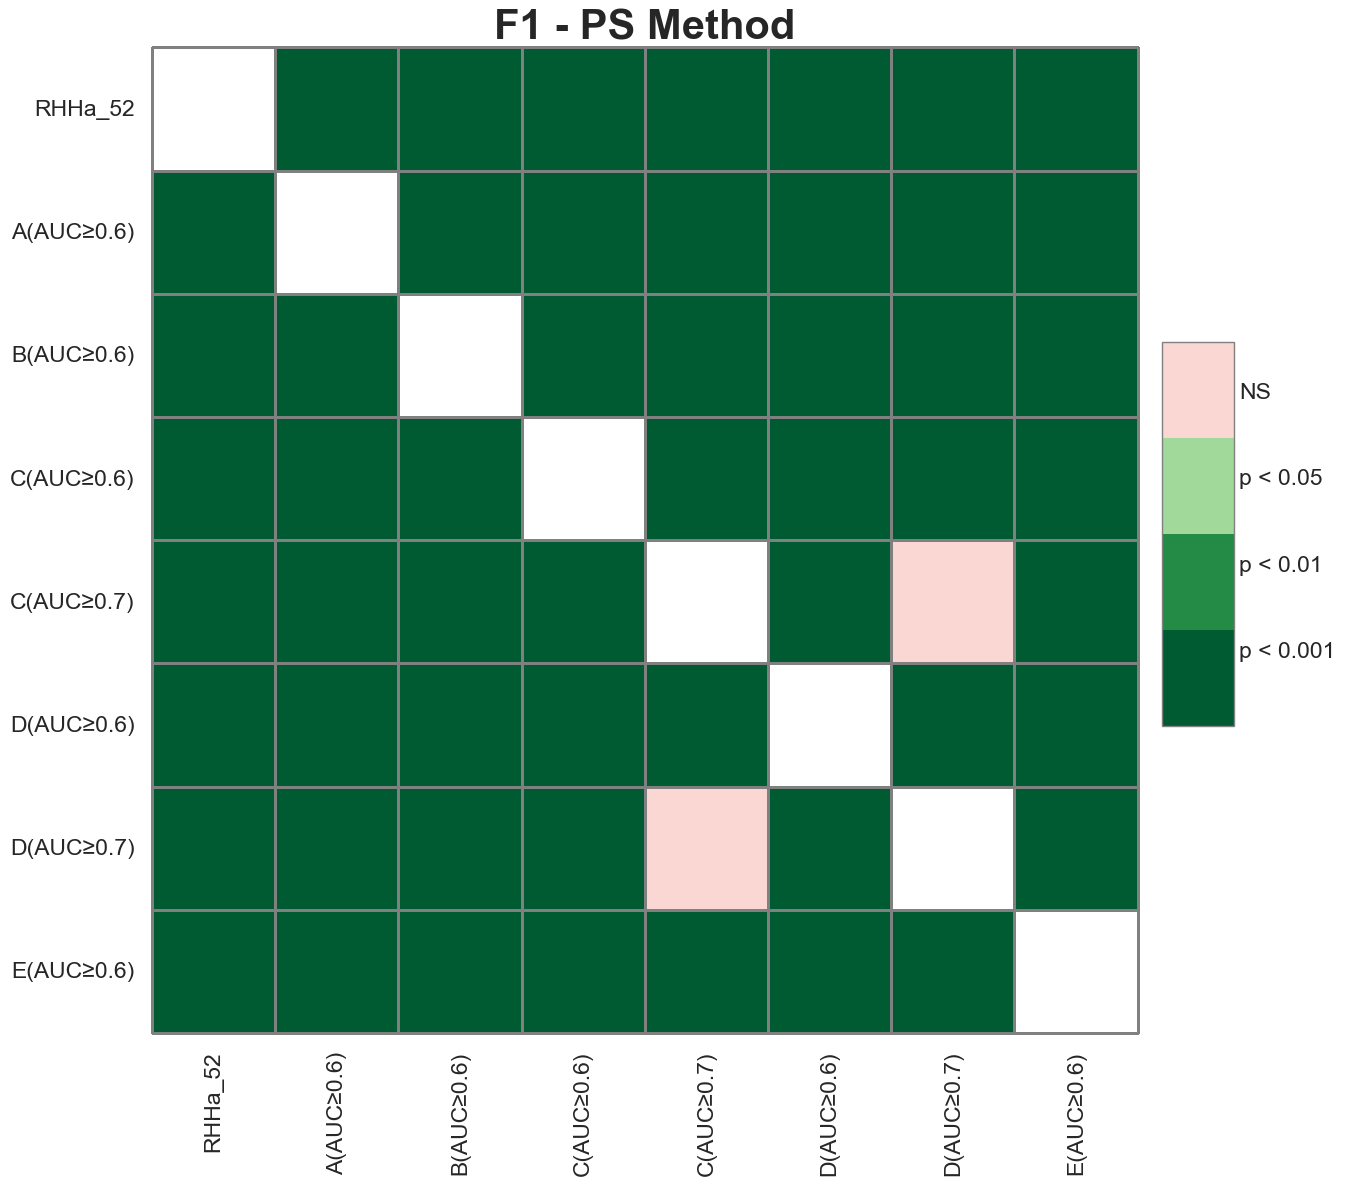

In [28]:
df_melt = pd.melt(F1_stacking_new.reset_index(), id_vars=['index'], value_vars=F1_stacking_new.columns)
df_melt.columns = ['index', 'Name', 'F1']
pc =sp.posthoc_wilcoxon(df_melt, val_col='F1', group_col='Name', p_adjust='holm')
plt.figure(figsize = (18,12.8))
plt.title("F1 - PS Method", fontsize = 30, weight = 'semibold')
heatmap_args = {'linewidths': 1, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.80, 0.35, 0.04, 0.3]}
sign_plot(pc, **heatmap_args)
plt.savefig(f"{work_dir}/image-stacking/F1 Comparison of Stacking Method- posthoc Wilcoxon test.png", dpi = 600)

# 4. Pharmacophore-score Stacking- SS


D (AUC >=0.6) for SS method

In [29]:
import glob
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
import os
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score,  roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn.metrics import accuracy_score, make_scorer

cha = pd.read_csv(f'{work_dir}/data-final/CPS50-AUC6.csv').drop(["Unnamed: 0"], axis = 1)
    
rescore = []
for j in cha.columns:
    if "rescore" in j:
        rescore.append(j)
data = pd.concat([cha.Active, cha[rescore]], axis = 1)
display(data)
    
#train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['Active'], axis = 1), 
                                                        data.Active, test_size=0.2, random_state=42, stratify = data.Active)
    
#Internal: cross-validation
print("*******Internal********")
cv = RepeatedStratifiedKFold(n_repeats = 3, n_splits=10, random_state=42)
clf = XGBClassifier(random_state=42)

auc_SS = cross_val_score(clf, X_train, y_train, cv=cv, scoring ='roc_auc')
print(f'AUC = {round(np.mean(auc_SS),3)}±{round(np.std(auc_SS),3)}')

    
GH_SS = cross_val_score(clf, X_train, y_train, cv=cv, scoring =GH_scoring)
print(f'GH = {round(np.mean(GH_SS),3)}±{round(np.std(GH_SS),3)}')

    
f1_SS = cross_val_score(clf, X_train, y_train, cv=cv, scoring ='f1')
print(f'F1 = {round(np.mean(f1_SS),3)}±{round(np.std(f1_SS),3)}')

ef1_SS = cross_val_score(clf, X_train, y_train, cv=cv, scoring =EF1_scoring)
print(f'EF1 = {round(np.mean(ef1_SS),3)}±{round(np.std(ef1_SS),3)}')    

#Extenal
print("*******External********")
clf =  XGBClassifier(random_state=42)
clf = clf.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test),))

ext_f1_SS, ext_auc_SS, ext_gh_SS, ext_ef1_SS = get_external(y_test, clf.predict(X_test), clf.predict_proba(X_test)[:, 1])
    
print('AUC =',  ext_auc_SS)
print('GH =', ext_gh_SS)
print('F1 =', ext_f1_SS)
print('EF1 =', ext_ef1_SS)

,Active,hhaa_21_rescore,hhaa_33_rescore,hhha_18_rescore,hhha_50_rescore,hhha_52_rescore,hhha_56_rescore,hhha_58_rescore,hhha_68_rescore,hhha_71_rescore,...,rhha_96_rescore,rhhh_12_rescore,rhhh_19_rescore,rrha_16_rescore,rrha_21_rescore,rrha_26_rescore,rrha_4_rescore,rrha_5_rescore,rrha_8_rescore,rrhh_6_rescore
0,1.0,0.000000,0.000000,0.186747,0.244747,0.000000,0.000000,0.000000,0.677225,0.000000,...,0.000000,0.000000,0.783447,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1,1.0,0.000000,0.000000,0.370134,0.000000,0.424123,0.455236,0.000000,0.000000,0.000000,...,0.000000,0.135337,0.548466,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
2,1.0,0.000000,0.000000,0.428374,0.375436,0.618544,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.382682,0.365538,0.000000,0.000000,0.000000,0.0,0.0,0.000000
3,1.0,0.000000,0.000000,0.405948,0.278341,0.759230,0.408909,0.000000,0.517896,0.000000,...,0.206006,0.786794,0.479039,0.673772,0.000000,0.000000,0.000000,0.0,0.0,0.000000
4,1.0,0.000000,0.000000,0.432919,0.420194,0.567280,0.369195,0.000000,0.543932,0.000000,...,0.218299,0.000000,0.757370,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45207,0.0,0.649577,0.000000,0.300481,0.325291,0.436084,0.000000,0.000000,0.475118,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
45208,0.0,0.444976,0.000000,0.431315,0.318718,0.474631,0.000000,0.000000,0.930788,0.000000,...,0.000000,0.586418,0.703720,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
45209,0.0,0.228896,0.000000,0.501067,0.284062,0.000000,0.000000,0.000000,0.263052,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.569912
45210,0.0,0.000000,0.126758,0.532502,0.239290,0.627248,0.000000,0.000000,0.548171,0.000000,...,0.000000,0.797265,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.310100


*******Internal********
AUC = 0.994±0.007
GH = 0.956±0.015
F1 = 0.911±0.031
EF1 = 50.07±0.211
*******External********
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8863
         1.0       0.99      0.81      0.89       180

    accuracy                           1.00      9043
   macro avg       0.99      0.90      0.94      9043
weighted avg       1.00      1.00      1.00      9043

AUC = 0.9890568781576342
GH = 0.946145138297483
F1 = 0.8895705521472393
EF1 = 50.0


# 5. Feature Selection Stacking- FS

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(30,20))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    

# Predict&Score Stacking

In [33]:
cha2 = pd.read_csv(f"{work_dir}/data-final/CPS50-AUC6.csv").drop(['Unnamed: 0'],axis =1)
print("Number of model including predict and rescore in tập D-AUC>0.6: ", cha2.shape[1] -1)

#split data
from sklearn.model_selection import train_test_split
X_train_cps50, X_test_cps50, y_train_cps50, y_test_cps50 = train_test_split(cha2.drop(['Active'], axis = 1), cha2.Active, test_size=0.2, random_state=42, stratify = cha2.Active)

#Internal
print("********Internal********")

from sklearn.model_selection import cross_val_score

clf_cps50 = XGBClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_repeats = 3, n_splits=10, random_state=42)

auc_GS_cps50 = cross_val_score(clf_cps50, X_train_cps50, y_train_cps50, cv=cv, scoring ='roc_auc')
print(f'AUC = {round(np.mean(auc_GS_cps50),3)}±{round(np.std(auc_GS_cps50),3)}')

GH_GS_cps50 = cross_val_score(clf_cps50, X_train_cps50, y_train_cps50, cv=cv, scoring =GH_scoring)
print(f'GH = {round(np.mean(GH_GS_cps50),3)}±{round(np.std(GH_GS_cps50),3)}')

f1_GS_cps50 = cross_val_score(clf_cps50, X_train_cps50, y_train_cps50, cv=cv, scoring ='f1')
print(f'F1 = {round(np.mean(f1_GS_cps50),3)}±{round(np.std(f1_GS_cps50),3)}')

ef1_GS_cps50 = cross_val_score(clf_cps50, X_train_cps50, y_train_cps50, cv=cv, scoring =EF1_scoring)
print(f'EF1 = {round(np.mean(ef1_GS_cps50),3)}±{round(np.std(ef1_GS_cps50),3)}')

#Internal
print("********External********")

model_cps50 =XGBClassifier(random_state=42)
model_cps50.fit(X_train_cps50, y_train_cps50)
print(classification_report(y_test_cps50, model_cps50.predict(X_test_cps50),))

ext_f1_GS_cps50, ext_auc_GS_cps50, ext_gh_GS_cps50,ext_ef1_GS_cps50 = get_external(y_test_cps50, model_cps50.predict(X_test_cps50),
                                                                        model_cps50.predict_proba(X_test_cps50)[:, 1])

print('AUC =', ext_auc_GS_cps50)
print('GH =', ext_gh_GS_cps50)
print('F1 =', ext_f1_GS_cps50)
print('EF1 =', ext_ef1_GS_cps50)

Number of model including predict and rescore in tập D-AUC>0.6:  98
********Internal********
AUC = 0.994±0.006
GH = 0.955±0.017
F1 = 0.909±0.034
EF1 = 50.07±0.211
********External********
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8863
         1.0       0.99      0.81      0.89       180

    accuracy                           1.00      9043
   macro avg       0.99      0.90      0.94      9043
weighted avg       1.00      1.00      1.00      9043

AUC = 0.9890568781576341
GH = 0.946145138297483
F1 = 0.8895705521472393
EF1 = 50.0


# Feature selection- Random Forest

In [34]:
cha2 = pd.read_csv(f"{work_dir}/data-final/CPS50-AUC6.csv").drop(['Unnamed: 0'],axis =1)
print("Number of model including predict and rescore in tập D-AUC>0.6: ", cha2.shape[1] -1)

#split data
from sklearn.model_selection import train_test_split
X_train_cps50, X_test_cps50, y_train_cps50, y_test_cps50 = train_test_split(cha2.drop(['Active'], axis = 1), cha2.Active, test_size=0.2, random_state=42, stratify = cha2.Active)

#feature selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
model_cps50 = RandomForestClassifier(random_state=42)
model_cps50.fit(X_train_cps50, y_train_cps50)
select_cps50 =  SelectFromModel(model_cps50, prefit=True)

X_train_new_cps50 = select_cps50.transform(X_train_cps50.values)
X_test_new_cps50 = select_cps50.transform(X_test_cps50.values)
model_cps50 = XGBClassifier(random_state=42)
model_cps50.fit(X_train_new_cps50, y_train_cps50)

#Internal
print("********Internal********")

from sklearn.model_selection import cross_val_score

clf_cps50 = XGBClassifier(random_state=42)
cv = RepeatedStratifiedKFold(n_repeats = 3, n_splits=10, random_state=42)

auc_FS_cps50 = cross_val_score(clf_cps50, X_train_new_cps50, y_train_cps50, cv=cv, scoring ='roc_auc')
print(f'AUC = {round(np.mean(auc_FS_cps50),3)}±{round(np.std(auc_FS_cps50),3)}')

f1_FS_cps50 = cross_val_score(clf_cps50, X_train_new_cps50, y_train_cps50, cv=cv, scoring ='f1')
print(f'F1 = {round(np.mean(f1_FS_cps50),3)}±{round(np.std(f1_FS_cps50),3)}')

GH_FS_cps50 = cross_val_score(clf_cps50, X_train_new_cps50, y_train_cps50, cv=cv, scoring =GH_scoring)
print(f'GH = {round(np.mean(GH_FS_cps50),3)}±{round(np.std(GH_FS_cps50),3)}')

EF1_FS_cps50 = cross_val_score(clf_cps50, X_train_new_cps50, y_train_cps50, cv=cv, scoring =EF1_scoring)
print(f'EF1 = {round(np.mean(EF1_FS_cps50),3)}±{round(np.std(EF1_FS_cps50),3)}')

#Internal
print("********External********")

model_cps50 =XGBClassifier(random_state=42)
model_cps50.fit(X_train_new_cps50, y_train_cps50)
print(classification_report(y_test_cps50, model_cps50.predict(X_test_new_cps50),))

ext_f1_FS_cps50, ext_auc_FS_cps50, ext_gh_FS_cps50,ext_ef1_FS_cps50 = get_external(y_test_cps50, model_cps50.predict(X_test_new_cps50),
                                                                        model_cps50.predict_proba(X_test_new_cps50)[:, 1])

print('AUC =', ext_auc_FS_cps50)
print('GH =', ext_gh_FS_cps50)
print('F1 =', ext_f1_FS_cps50)
print('EF1 =', ext_ef1_FS_cps50)

Number of model including predict and rescore in tập D-AUC>0.6:  98
********Internal********
AUC = 0.994±0.007
F1 = 0.907±0.033
GH = 0.953±0.017
EF1 = 50.07±0.211
********External********
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8863
         1.0       0.99      0.83      0.90       180

    accuracy                           1.00      9043
   macro avg       0.99      0.91      0.95      9043
weighted avg       1.00      1.00      1.00      9043

AUC = 0.990994396178871
GH = 0.9518370378728045
F1 = 0.9030303030303028
EF1 = 50.0


Number of model choosen from feature_selection:  44


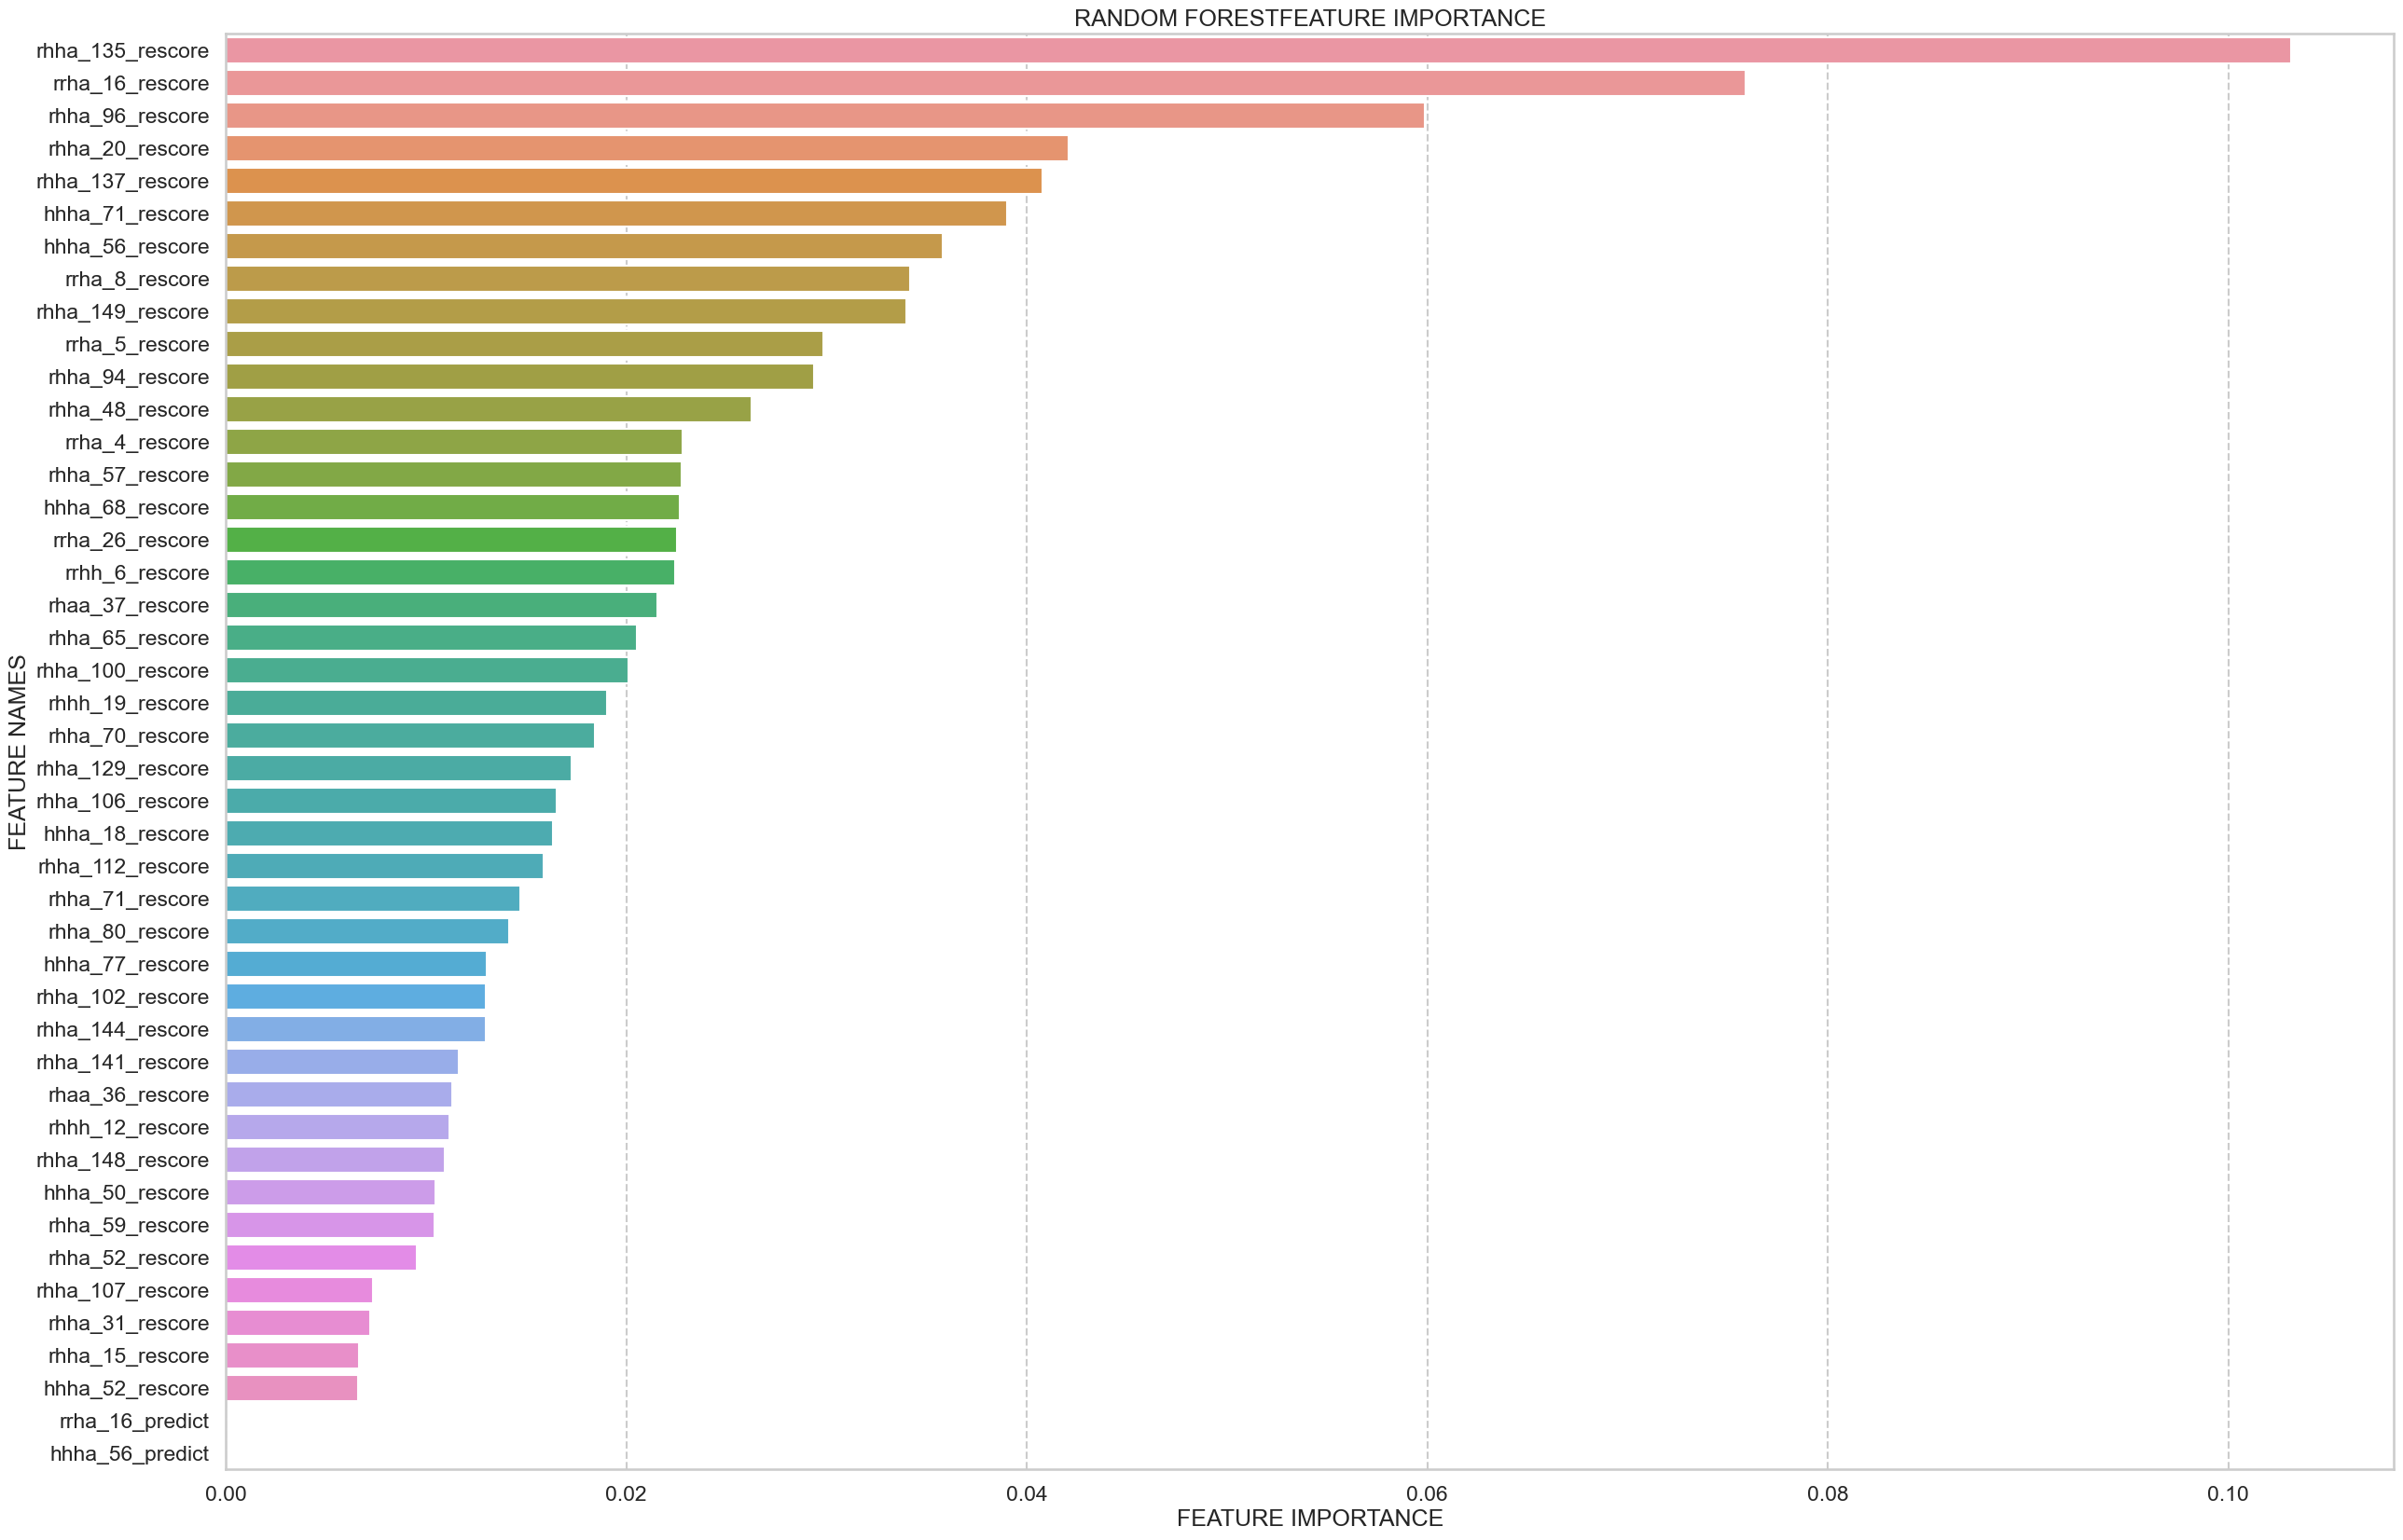

In [35]:
#plot_feature_importance
from sklearn.feature_selection import SelectFromModel
model_cps50_1 = RandomForestClassifier(random_state=42)
model_cps50_1.fit(X_train_cps50, y_train_cps50)
select_cps50_1 =  SelectFromModel(model_cps50_1, prefit=True)
name = select_cps50_1.get_feature_names_out(X_train_cps50.columns)

print("Number of model choosen from feature_selection: ",name.shape[0])
plot_feature_importance(model_cps50.feature_importances_, name ,'RANDOM FOREST')

# 6. Compare Model

Compare Internal
- RHHa_52s
- Stacking: Pharmacophore-predict Stacking,Pharmacophore-score Stacking, Global Stacking, Feature selection Stacking


In [36]:
AUC_internal = pd.DataFrame(AUC_stacking['D(AUC≥0.6)'])
AUC_internal.columns = ['PS']
AUC_internal.insert(0,"RHHa_52",auc_rhha_52)
AUC_internal.insert(2,'SS',auc_SS)
AUC_internal.insert(3,'GS',auc_GS_cps50)
AUC_internal.insert(4,'FS',auc_FS_cps50)
AUC_internal

,RHHa_52,PS,SS,GS,FS
0,0.805,0.989637,0.997732,0.996200,0.996074
1,0.814,0.997967,0.999412,0.999111,0.999361
2,0.816,0.991208,0.992098,0.992658,0.991569
3,0.789,0.976363,0.991048,0.989743,0.983937
4,0.794,0.997050,0.995675,0.995675,0.996877
5,0.842,0.999150,0.999871,0.999871,0.999879
6,0.881,0.995208,0.999322,0.999322,0.999287
7,0.829,0.998264,0.999549,0.999549,0.999330
8,0.846,0.965174,0.968222,0.972218,0.974546
9,0.807,0.999559,0.999718,0.999726,0.999674


In [37]:
GH_internal = pd.DataFrame(GH_stacking['D(AUC≥0.6)'])
GH_internal.columns = ['PS']
GH_internal.insert(0,"RHHa_52",GH_rhha_52)
GH_internal.insert(2,'SS',GH_SS)
GH_internal.insert(3,'GS',GH_GS_cps50)
GH_internal.insert(4,'FS',GH_FS_cps50)
GH_internal.head()

,RHHa_52,PS,SS,GS,FS
0,0.125,0.956761,0.954861,0.951389,0.954861
1,0.132,0.925865,0.965278,0.965278,0.968750
2,0.13,0.934722,0.940972,0.937500,0.951389
3,0.126,0.867460,0.930556,0.930556,0.927083
4,0.126,0.942095,0.968750,0.968750,0.972222


In [38]:
F1_internal = pd.DataFrame(F1_stacking['D(AUC≥0.6)'])
F1_internal.columns = ['PS']
F1_internal.insert(0,"RHHa_52",f1_rhha_52)
F1_internal.insert(2,'SS',f1_SS)
F1_internal.insert(3,'GS',f1_GS_cps50)
F1_internal.insert(4,'FS',f1_FS_cps50)
F1_internal.head()

,RHHa_52,PS,SS,GS,FS
0,0.067,0.926471,0.900763,0.892308,0.900763
1,0.071,0.897059,0.925373,0.925373,0.933333
2,0.069,0.876923,0.866142,0.857143,0.892308
3,0.067,0.770492,0.838710,0.838710,0.829268
4,0.067,0.893939,0.933333,0.933333,0.941176


In [39]:
EF1_internal = pd.DataFrame(EF1_stacking['D(AUC≥0.6)'])
EF1_internal.columns = ['PS']
EF1_internal.insert(0,"RHHa_52",ef1_rhha_52)
EF1_internal.insert(2,'SS',ef1_SS)
EF1_internal.insert(3,'GS',ef1_GS_cps50)
EF1_internal.insert(4,'FS',EF1_FS_cps50)
EF1_internal.head()

,RHHa_52,PS,SS,GS,FS
0,19.444,50.0,50.0,50.0,50.0
1,18.056,50.0,50.0,50.0,50.0
2,20.833,50.0,50.0,50.0,50.0
3,13.889,50.0,50.0,50.0,50.0
4,19.444,50.0,50.0,50.0,50.0


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


RHHa_52 vs. PS: Custom statistical test, P_val:1.863e-09
PS vs. SS: Custom statistical test, P_val:1.205e-02
SS vs. GS: Custom statistical test, P_val:9.090e-01
GS vs. FS: Custom statistical test, P_val:9.354e-01


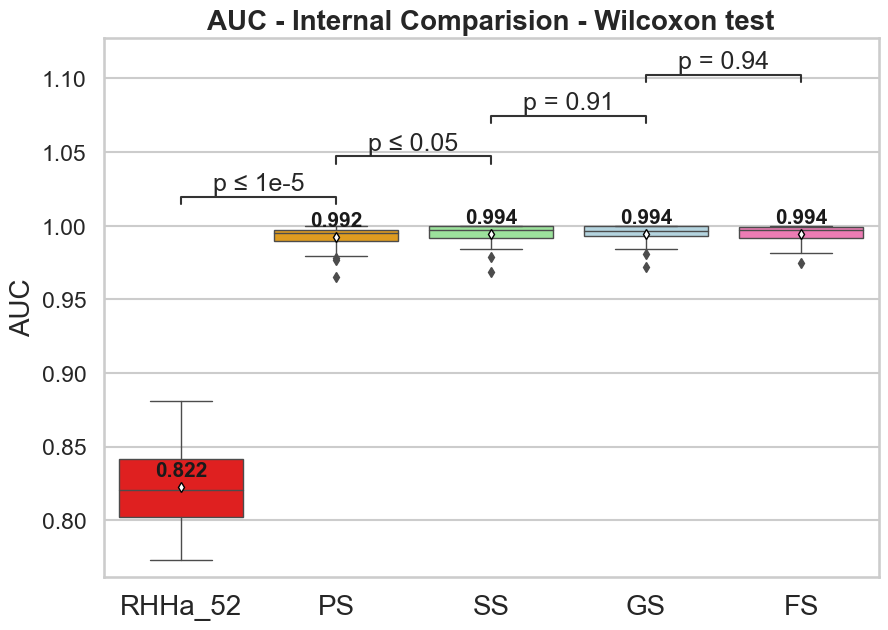

In [54]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = pd.melt(AUC_internal.reset_index(), id_vars=['index'], value_vars=AUC_internal.columns)
df_melt.columns = ['index', 'Model', 'AUC']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)

stat_results = [wilcoxon(AUC_internal['RHHa_52'].astype('float'), AUC_internal['PS'].astype('float'), alternative="two-sided"),
                wilcoxon(AUC_internal['PS'].astype('float'), AUC_internal['SS'].astype('float'), alternative="two-sided"),
                wilcoxon(AUC_internal['SS'].astype('float'), AUC_internal['GS'].astype('float'), alternative="two-sided"),
                wilcoxon(AUC_internal['GS'].astype('float'), AUC_internal['FS'].astype('float'), alternative="two-sided")
               ]

pvalues = [result.pvalue for result in stat_results]
plotting_parameters = {
    'data':    df_melt,
    'x':       'Model',
    'y':       'AUC',
    'palette': subcat_palette[1:]
}

pairs = [('RHHa_52', 'PS'),
         ('PS', 'SS'),
         ('SS', 'GS'),
         ('GS', 'FS')
        ]


sns.set_style("whitegrid")
plt.figure(figsize = (10,7))

my_colors = {'RHHa_52': 'red', 
             'PS': 'orange', 
             'SS': 'lightgreen',
             'GS': 'lightblue',
             'FS': '#FF69B4'}


ax = sns.boxplot(x='Model', y='AUC', data=df_melt, palette=my_colors, showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"})

mean = round(AUC_internal.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =AUC_internal.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.008

for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], 
    horizontalalignment='center',color='k',weight='semibold', fontsize = 15)


annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(text_format="simple")
annotator.set_pvalues_and_annotate(pvalues)

ax.set_ylabel('AUC', fontsize = 20)
ax.set_xlabel(None)
ax.set_xticklabels(labels = AUC_internal.columns, fontsize = 20)
ax.set_title("AUC - Internal Comparision - Wilcoxon test",fontsize = 20, weight ='semibold')
plt.savefig(f"{work_dir}/image-stacking/AUC Internal Comparision.png", dpi = 600)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


RHHa_52 vs. PS: Custom statistical test, P_val:1.863e-09
PS vs. SS: Custom statistical test, P_val:2.849e-06
SS vs. GS: Custom statistical test, P_val:5.769e-02
GS vs. FS: Custom statistical test, P_val:2.496e-01


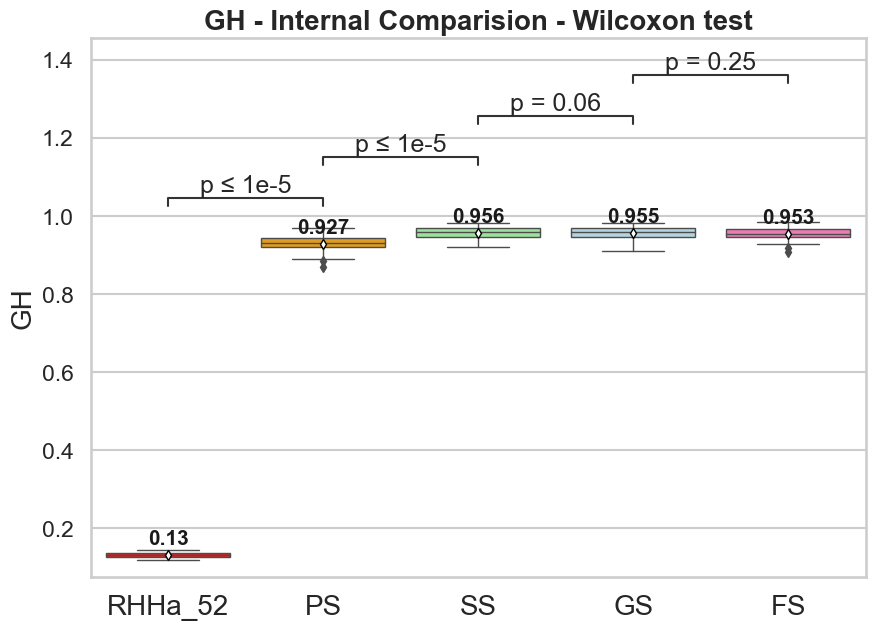

In [59]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = pd.melt(GH_internal.reset_index(), id_vars=['index'], value_vars=GH_internal.columns)
df_melt.columns = ['index', 'Model', 'GH']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)

stat_results = [wilcoxon(GH_internal['RHHa_52'].astype('float'), GH_internal['PS'].astype('float'), alternative="two-sided"),
                wilcoxon(GH_internal['PS'].astype('float'), GH_internal['SS'].astype('float'), alternative="two-sided"),
                wilcoxon(GH_internal['SS'].astype('float'), GH_internal['GS'].astype('float'), alternative="two-sided"),
                wilcoxon(GH_internal['GS'].astype('float'), GH_internal['FS'].astype('float'), alternative="two-sided")
               ]

pvalues = [result.pvalue for result in stat_results]
plotting_parameters = {
    'data':    df_melt,
    'x':       'Model',
    'y':       'GH',
    'palette': subcat_palette[1:]
}

pairs = [('RHHa_52', 'PS'),
         ('PS', 'SS'),
         ('SS', 'GS'),
         ('GS', 'FS')
        ]


sns.set_style("whitegrid")
plt.figure(figsize = (10,7))

my_colors = {'RHHa_52': 'red', 
             'PS': 'orange', 
             'SS': 'lightgreen',
             'GS': 'lightblue',
             'FS': '#FF69B4'}


ax = sns.boxplot(x='Model', y='GH', data=df_melt, palette=my_colors, showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"})

mean = round(GH_internal.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =GH_internal.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.03

for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], 
    horizontalalignment='center',color='k',weight='semibold', fontsize = 15)


annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(text_format="simple")
annotator.set_pvalues_and_annotate(pvalues)

ax.set_ylabel('GH', fontsize = 20)
ax.set_xlabel(None)
ax.set_xticklabels(labels = GH_internal.columns, fontsize = 20)
ax.set_title("GH - Internal Comparision - Wilcoxon test",fontsize = 20, weight ='semibold')
plt.savefig(f"{work_dir}/image-stacking/GH Internal Comparision.png", dpi = 600)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


RHHa_52 vs. PS: Custom statistical test, P_val:1.863e-09
PS vs. SS: Custom statistical test, P_val:1.455e-05
SS vs. GS: Custom statistical test, P_val:6.910e-03
GS vs. FS: Custom statistical test, P_val:4.873e-01


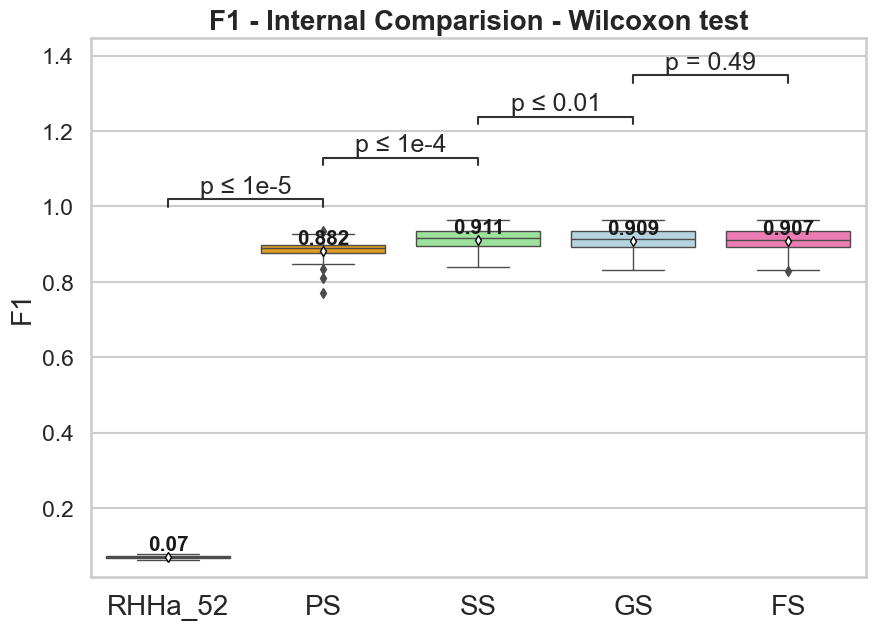

In [63]:
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu, normaltest, wilcoxon
from statannot import add_stat_annotation
import seaborn as sns
import matplotlib.pyplot as plt

df_melt = pd.melt(F1_internal.reset_index(), id_vars=['index'], value_vars=F1_internal.columns)
df_melt.columns = ['index', 'Model', 'F1']
subcat_palette = sns.dark_palette("#8BF", reverse=True, n_colors=5)

stat_results = [wilcoxon(F1_internal['RHHa_52'].astype('float'), F1_internal['PS'].astype('float'), alternative="two-sided"),
                wilcoxon(F1_internal['PS'].astype('float'), F1_internal['SS'].astype('float'), alternative="two-sided"),
                wilcoxon(F1_internal['SS'].astype('float'), F1_internal['GS'].astype('float'), alternative="two-sided"),
                wilcoxon(F1_internal['GS'].astype('float'), F1_internal['FS'].astype('float'), alternative="two-sided")
               ]

pvalues = [result.pvalue for result in stat_results]
plotting_parameters = {
    'data':    df_melt,
    'x':       'Model',
    'y':       'F1',
    'palette': subcat_palette[1:]
}

pairs = [('RHHa_52', 'PS'),
         ('PS', 'SS'),
         ('SS', 'GS'),
         ('GS', 'FS')
        ]


sns.set_style("whitegrid")
plt.figure(figsize = (10,7))

my_colors = {'RHHa_52': 'red', 
             'PS': 'orange', 
             'SS': 'lightgreen',
             'GS': 'lightblue',
             'FS': '#FF69B4'}


ax = sns.boxplot(x='Model', y='F1', data=df_melt, palette=my_colors, showmeans=True ,meanprops={"marker":"d",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"5"})

mean = round(F1_internal.mean(),3)
data = np.array(mean)   
ser = pd.Series(data, index =F1_internal.columns)

dict_columns = {'Mean':mean,}
df = pd.DataFrame(dict_columns)

vertical_offset = df["Mean"].median()*0.02
for xtick in ax.get_xticks():
    ax.text(xtick,ser[xtick]+ vertical_offset,ser[xtick], 
    horizontalalignment='center',color='k',weight='semibold', fontsize = 15)


annotator = Annotator(ax, pairs, **plotting_parameters)
annotator.configure(text_format="simple")
annotator.set_pvalues_and_annotate(pvalues)

ax.set_ylabel('F1', fontsize = 20)
ax.set_xlabel(None)
ax.set_xticklabels(labels = F1_internal.columns, fontsize = 20)
ax.set_title("F1 - Internal Comparision - Wilcoxon test",fontsize = 20, weight ='semibold')
plt.savefig(f"{work_dir}/image-stacking/F1 Internal Comparision.png", dpi = 600)

In [71]:
table

,Model,Sensitivity,Specificity,Precision,F1-score,AP,AUCROC,logAUCROC,BedROC,GH,EF1%,RIE
0,rhha_52,0.828,0.565,0.037,0.071,0.26,0.811,0.462,0.382,0.133,18.333,0.962


In [121]:
External_dict = {'AUC':[0.811,0.984946782504043,ext_auc_SS,ext_auc_GS_cps50,ext_auc_FS_cps50],
               "GH":[0.133,0.916125287267588,ext_gh_SS,ext_gh_GS_cps50,ext_gh_FS_cps50],
            "F1":[0.071,0.8734939759036146,ext_f1_SS,ext_f1_GS_cps50,ext_f1_FS_cps50],
            "EF1":[18.333,50.0,ext_ef1_SS,ext_ef1_GS_cps50,ext_ef1_FS_cps50]}
External = pd.DataFrame(External_dict, index=["RHHa_52",'PS',"SS","GS","FS"])
External

,AUC,GH,F1,EF1
RHHa_52,0.811000,0.133000,0.071000,18.333
PS,0.984947,0.916125,0.873494,50.000
SS,0.989057,0.946145,0.889571,50.000
GS,0.989057,0.946145,0.889571,50.000
FS,0.990994,0.951837,0.903030,50.000


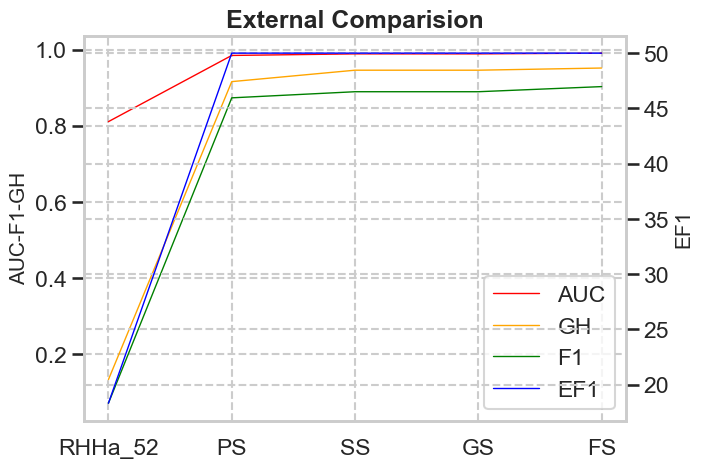

In [144]:
colors = ['red', 'orange', 'green','blue']

ax = External.loc[:, External.columns[:3]].plot(label=External.columns[:3], color=colors[:3], figsize=(7, 5))
ax.set_ylabel(ylabel='AUC-F1-GH',fontsize = 15)
lines, labels = ax.get_legend_handles_labels()


ax_new = ax.twinx()
ax_new.spines['right'].set_position(('axes',1))
External.loc[:, External.columns[3]].plot(ax=ax_new, label=External.columns[3], color=colors[3 % len(colors)],  figsize=(7, 5))
ax_new.set_ylabel(ylabel=External.columns[3],fontsize = 15)
        
# Proper legend position
line, label = ax_new.get_legend_handles_labels()
lines += line
labels += label
ax.set_title("External Comparision",fontsize = 18, weight ='semibold')
ax.legend(lines, labels, loc=0)
plt.savefig(f"{work_dir}/image-stacking/External Comparision.png", dpi = 1000)